<h1>Machine Learning and Deep Learning<h1>

<h3>KAN-CDSCO2004U<h3>



Helle Rasmussen: 176789 <br>
Ava Kathinka Bang: 177120

**Table of Contents:**
1. Data Collection & Merging
2. Data Pre-Processing
3. Train-Test Split
4. Builing Our ML Models

# 1 Data and Library Importation

In [ ]:
!pip install -q imbalanced-learn
!pip install xgboost
!pip install optuna

In [ ]:
# Libraries for data manipulation and analysis
import pandas as pd               # Used for data manipulation
import numpy as np                # Used for numerical operations

# Libraries for plotting
import matplotlib.pyplot as plt   # Used for plotting
import seaborn as sns             # Used for advanced plotting

# Machine Learning Libraries
from sklearn.model_selection import train_test_split  # Used to split data
from sklearn.preprocessing import LabelEncoder        # Used for nominal variables
from sklearn.preprocessing import StandardScaler      # Used for feature scaling
from sklearn.tree import DecisionTreeClassifier       # Used for decision tree
from sklearn.ensemble import RandomForestClassifier   # Used for random forest
from sklearn.linear_model import LogisticRegression   # Used for logistic regression
from sklearn.model_selection import cross_val_score   # Used or cross value score
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score)  # Performance metrics

from xgboost import XGBClassifier                # Used for XGBoost model
import xgboost as xgb

# Libraries for handling imbalanced data
from imblearn.over_sampling import ADASYN    # Used to handle imbalanced data

# Hyperparameter optimization
import optuna

# Utility libraries
import itertools
import math
import warnings

In [ ]:
df_main = pd.read_excel("https://raw.githubusercontent.com/avakbang/ML-DL/29c91149f34786f103a932cde5e0ca1ac7d15200/CustomerChurn.xlsx", engine='openpyxl')
df_demo = pd.read_excel("https://raw.githubusercontent.com/avakbang/ML-DL/29c91149f34786f103a932cde5e0ca1ac7d15200/Telco_customer_churn_demographics.xlsx", engine='openpyxl')
df_services = pd.read_excel("https://raw.githubusercontent.com/avakbang/ML-DL/29c91149f34786f103a932cde5e0ca1ac7d15200/Telco_customer_churn_services.xlsx", engine='openpyxl')

### 1.1 Data Filtering, Transformation and Combination


Merged all three dataset on Custome ID using left join

In [ ]:
df_merged = pd.merge(df_main, df_demo, on='Customer ID', how='left', suffixes=('', '_demo'))
df_merged = pd.merge(df_merged, df_services, on='Customer ID', how='left', suffixes=('', '_service'))

# Make sure to drop duplicate columns
df_merged = df_merged.drop(
  columns=[col for col in df_merged.columns if col.endswith('_demo') or col.endswith('_service')]
)

Checking how similar columns are to eachother, to double check that we havent include any columns that have the same purpose or show the same values


In [ ]:
threshold = 0.80 # 80 % match
for col1, col2 in itertools.combinations(df_merged.columns, 2):
  if df_merged[col1].equals(df_merged[col2]):
      print(f"{col1} and {col2} are exactly the same.")
  else:
      match_ratio = (df_merged[col1] == df_merged[col2]).mean()
      if match_ratio >= threshold:
          print(f"{col1} and {col2} are {match_ratio:.2%} similar.")

Partner and Married are exactly the same.
Partner and Referred a Friend are 97.44% similar.
Tenure and Tenure in Months are 99.84% similar.
Monthly Charges and Monthly Charge are exactly the same.
Married and Referred a Friend are 97.44% similar.
Total Refunds and Total Extra Data Charges are 83.05% similar.


In [ ]:
# drops columns that are exactly the same or almost the same
df_merged = df_merged.drop(['Married', 'Tenure in Months', 'Monthly Charge'], axis=1)

These columns where droppe because of redundancy or having a constant value.

In [ ]:
df = df_merged.drop(['LoyaltyID',
                      'Count',
                      'Under 30',
                      'Number of Dependents',
                      'Service ID',
                      'Quarter',
                      'Number of Referrals'
                      ], axis=1)
df.head()

Customer ID Senior Citizen Partner Dependents  Tenure Phone Service  \
0  7590-VHVEG             No     Yes         No       1            No   
1  5575-GNVDE             No      No         No      34           Yes   
2  3668-QPYBK             No      No         No       2           Yes   
3  7795-CFOCW             No      No         No      45            No   
4  9237-HQITU             No      No         No       2           Yes   

     Multiple Lines Internet Service Online Security Online Backup  ...  \
0  No phone service              DSL              No           Yes  ...   
1                No              DSL             Yes            No  ...   
2                No              DSL             Yes           Yes  ...   
3  No phone service              DSL             Yes            No  ...   
4                No      Fiber optic              No            No  ...   

  Internet Type Avg Monthly GB Download Device Protection Plan  \
0           DSL                      10                     No   
1           DSL                      16                    Yes   
2           DSL                      21                     No   
3           DSL                      10                    Yes   
4   Fiber Optic                      51                     No   

  Premium Tech Support Streaming Music Unlimited Data Total Refunds  \
0                   No              No            Yes          0.00   
1                   No              No            Yes          0.00   
2                   No              No            Yes          0.00   
3                  Yes              No            Yes          0.00   
4                   No              No            Yes          0.00   

   Total Extra Data Charges Total Long Distance Charges Total Revenue  
0                         0                        0.00         29.85  
1                         0                      581.06       2470.56  
2                         0                       20.94        129.09  
3                         0                        0.00       1840.75  
4                         0                       18.24        169.89  

[5 rows x 35 columns]

# 2 Data Pre-Processing
- missing values
- duplicated rows
- converting datatypes

In [ ]:
df.columns = df.columns.str.replace(' ', '_')

## 2.1 Dealing with Missing Values
- Offer and Internet_Type turned out to be missing a lot of data and were therefore dropped.

In [ ]:
# Replace empty strings and whitespaces with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# Check for missing values in all columns
print("Missing values in all columns:")
print(df.isna().sum()[df.isna().sum() > 0])

Missing values in all columns:
Total_Charges      11
Offer            3877
Internet_Type    1526
dtype: int64


<ipython-input-87-dc61bc387325>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(r'^\s*$', np.nan, regex=True)


In [ ]:
missing_values_col = ["Offer", "Internet_Type"]

for col in missing_values_col:
  print(f"{col}: {df[col].unique()}")

Offer: ['Offer E' nan 'Offer D' 'Offer C' 'Offer B' 'Offer A']
Internet_Type: ['DSL' 'Fiber Optic' 'Cable' nan]


In [ ]:
df = df.drop(columns=["Offer", "Internet_Type"])

In [ ]:
# Drop rows where Total_Charges has missing values
df = df.dropna(subset=['Total_Charges'])

## 2.2 Dealing with Duplicates

In [ ]:
duplicates = df[df.duplicated()]
print(f"Number of duplicate rows: {len(duplicates)}")

Number of duplicate rows: 0


Showing we had no duplicated rows, so no need for cleaning here

## 2.3 Categorical Values
- converting datatypes

Visualizing the distribution of our categorical values that had less than 10 unique counts

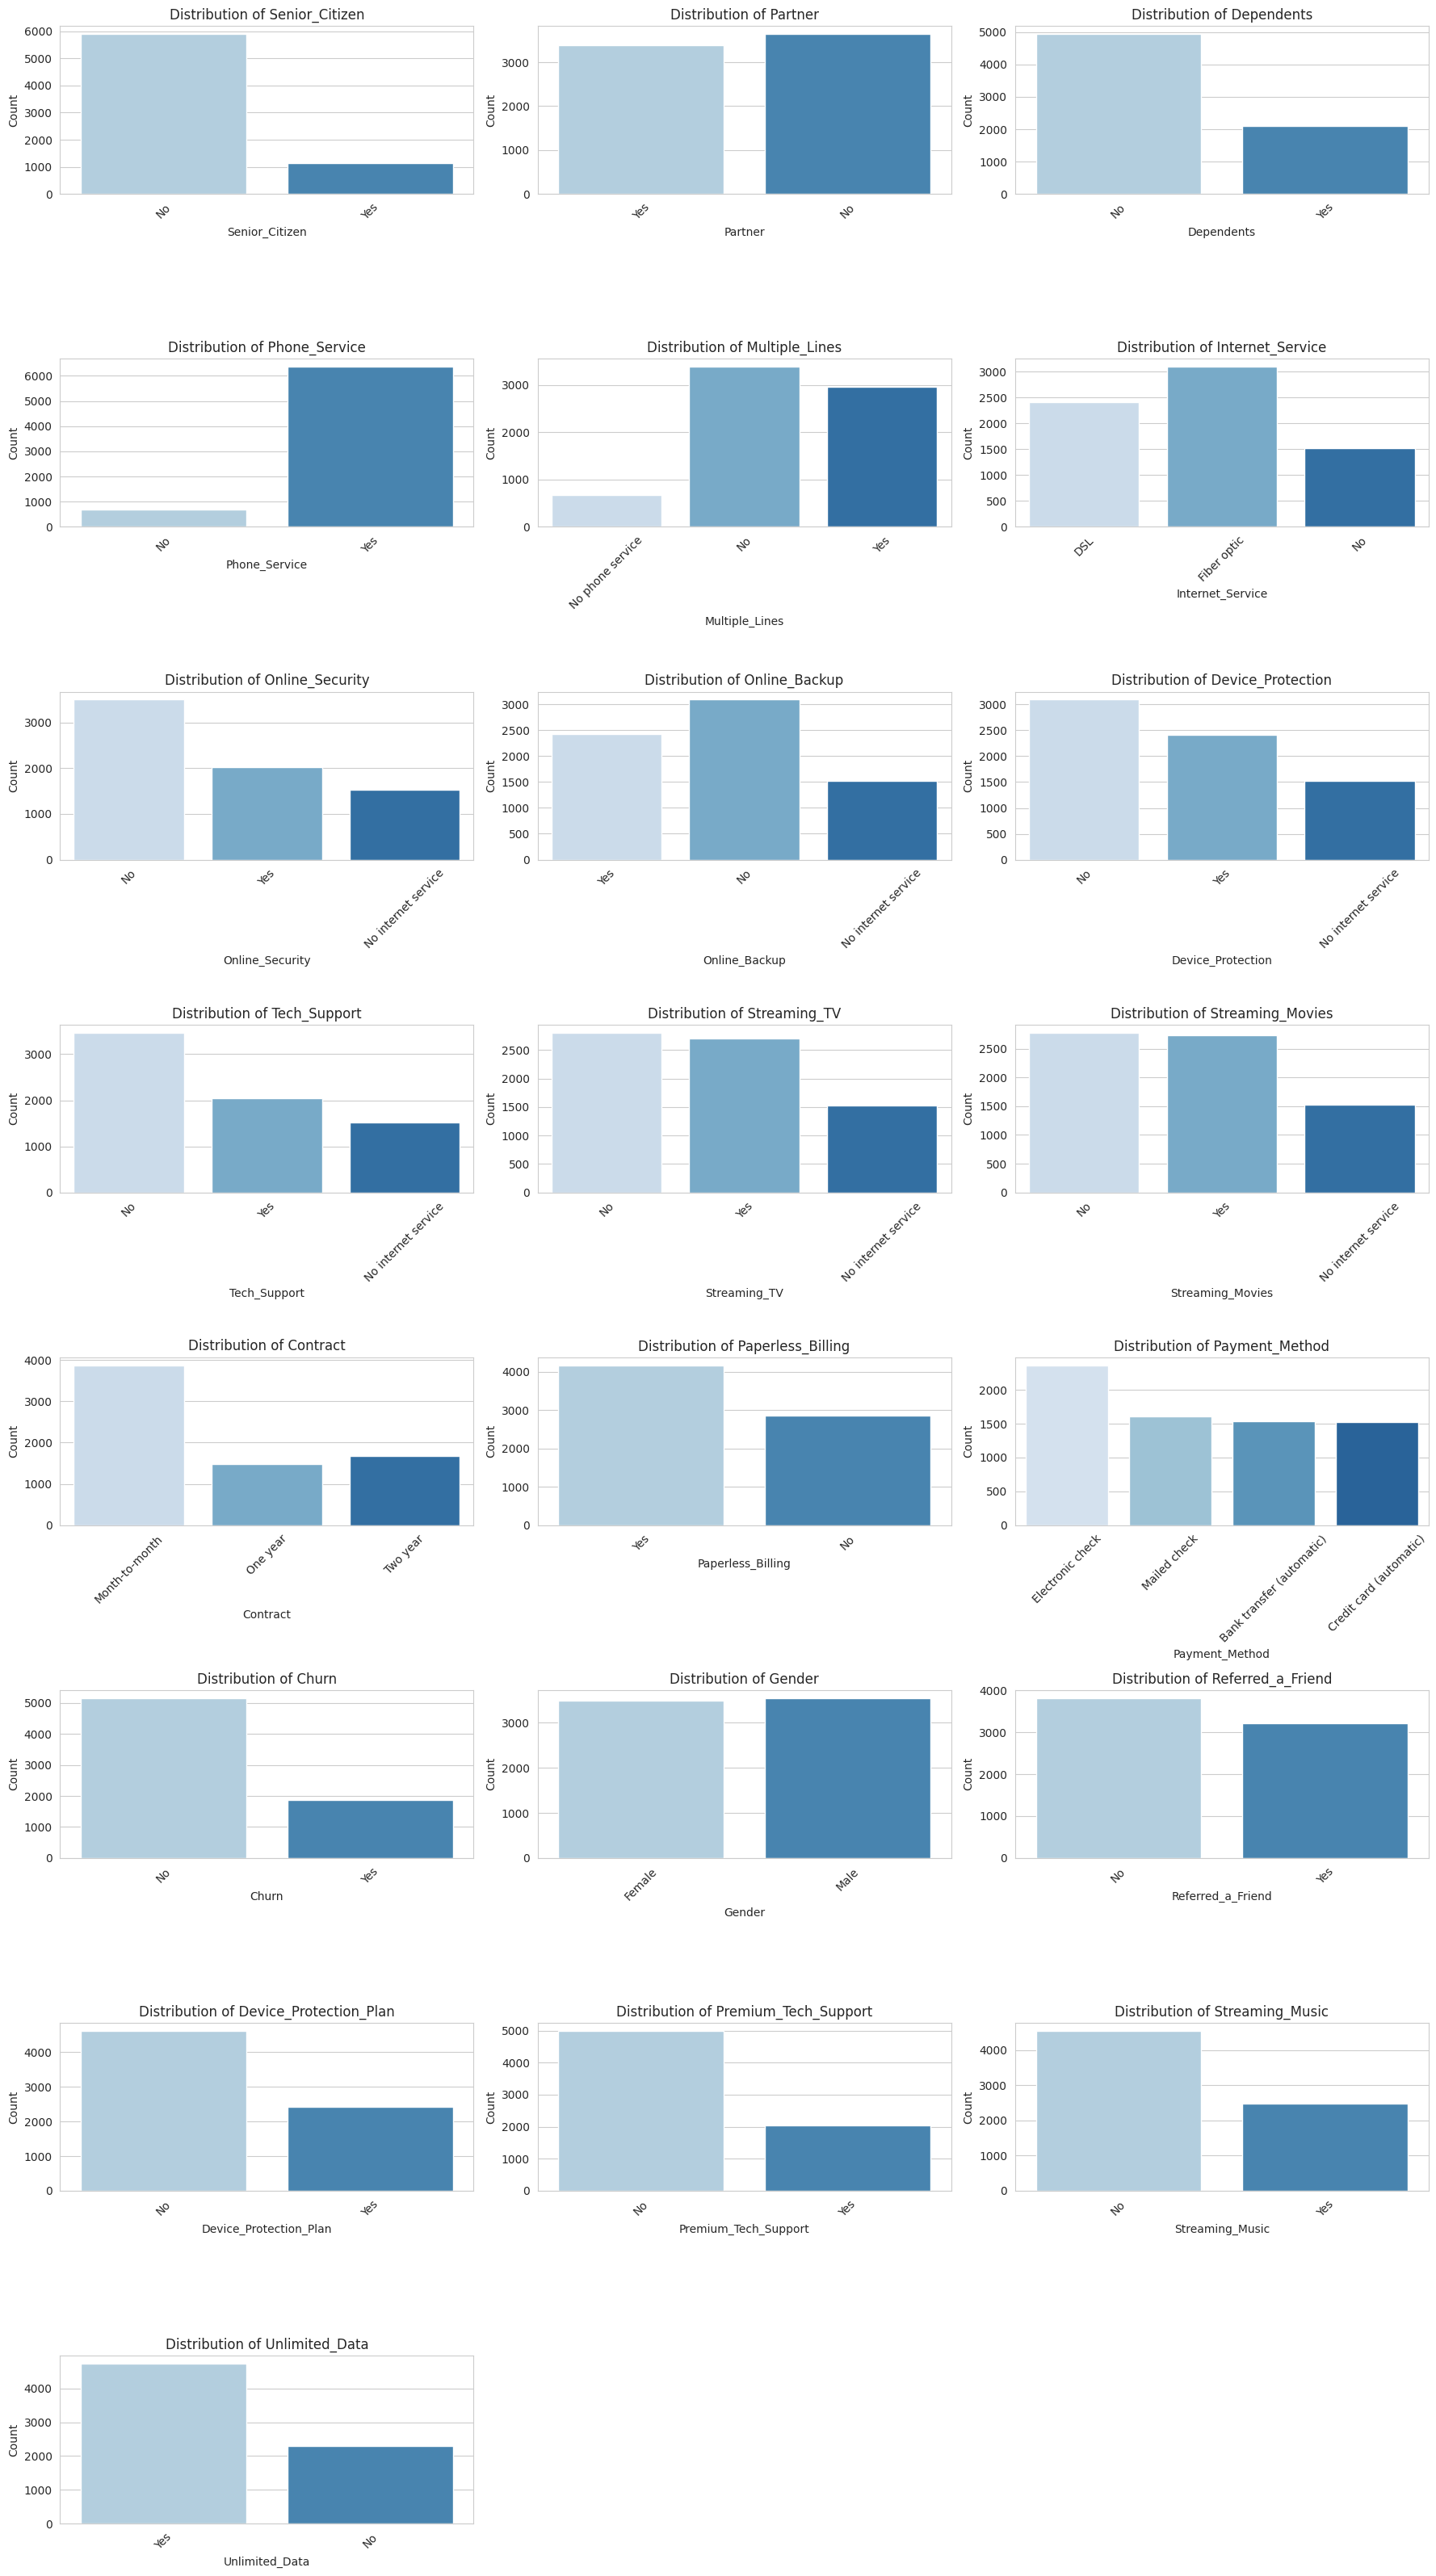

In [ ]:
categorical_cols = [col for col in df.columns
                    if df[col].nunique() <= 10 and df[col].dtype in ['object', 'bool', 'int64']]

numerical_cols = df.select_dtypes(include=['float64', 'int64'])

sns.set_style('whitegrid')

# Set grid size
n_plots = len(categorical_cols)
n_cols = 3
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
axes = axes.flatten()

# Plot each categorical feature
for i, col in enumerate(categorical_cols):
  sns.countplot(x=col, data=df, ax=axes[i], hue=col, palette='Blues', legend=False)
  axes[i].set_title(f'Distribution of {col}')
  axes[i].set_xlabel(col)
  axes[i].set_ylabel('Count')
  axes[i].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Overall the distribution looked natural.

### Boolean Features

Since non of our Boolean features have Boolean as their Dtype we change their Dtype into Boolean and map them to 0 and 1 values

In [ ]:
print("Features with only two unique values (boolean):\n")
for col in df.columns:
  if df[col].nunique() == 2:
      print(f"{col}: {df[col].unique()}")

Features with only two unique values (boolean):

Senior_Citizen: ['No' 'Yes']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
Phone_Service: ['No' 'Yes']
Paperless_Billing: ['Yes' 'No']
Churn: ['No' 'Yes']
Gender: ['Female' 'Male']
Referred_a_Friend: ['No' 'Yes']
Device_Protection_Plan: ['No' 'Yes']
Premium_Tech_Support: ['No' 'Yes']
Streaming_Music: ['No' 'Yes']
Unlimited_Data: ['Yes' 'No']


In [ ]:
# Convert all binary columns to boolean dtype
for column in df.columns:
  if df[column].nunique() == 2 and set(df[column].unique()) <= {0, 1}:
      df[column] = df[column].astype(bool)

In [ ]:
# Convert all columns with exactly two unique values to 0 and 1
for column in df.columns:
  if df[column].nunique() == 2:
      unique_vals = list(df[column].unique())
      df[column] = df[column].map({unique_vals[0]: 0, unique_vals[1]: 1})

In [ ]:
df.head()

Customer_ID  Senior_Citizen  Partner  Dependents  Tenure  Phone_Service  \
0  7590-VHVEG               0        0           0       1              0   
1  5575-GNVDE               0        1           0      34              1   
2  3668-QPYBK               0        1           0       2              1   
3  7795-CFOCW               0        1           0      45              0   
4  9237-HQITU               0        1           0       2              1   

     Multiple_Lines Internet_Service Online_Security Online_Backup  ...  \
0  No phone service              DSL              No           Yes  ...   
1                No              DSL             Yes            No  ...   
2                No              DSL             Yes           Yes  ...   
3  No phone service              DSL             Yes            No  ...   
4                No      Fiber optic              No            No  ...   

  Avg_Monthly_Long_Distance_Charges Avg_Monthly_GB_Download  \
0                              0.00                      10   
1                             17.09                      16   
2                             10.47                      21   
3                              0.00                      10   
4                              9.12                      51   

  Device_Protection_Plan Premium_Tech_Support Streaming_Music  Unlimited_Data  \
0                      0                    0               0               0   
1                      1                    0               0               0   
2                      0                    0               0               0   
3                      1                    1               0               0   
4                      0                    0               0               0   

  Total_Refunds  Total_Extra_Data_Charges  Total_Long_Distance_Charges  \
0          0.00                         0                         0.00   
1          0.00                         0                       581.06   
2          0.00                         0                        20.94   
3          0.00                         0                         0.00   
4          0.00                         0                        18.24   

   Total_Revenue  
0          29.85  
1        2470.56  
2         129.09  
3        1840.75  
4         169.89  

[5 rows x 33 columns]

### Object Variables

In [ ]:
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'], errors='coerce')

# Getting all variables that are object by selecting unique keys for all dtype object
object_variables_unique_values = {
  column: df[column].unique()
  for column in df.columns
  # Exclude 'Customer ID' from object-type analysis
  if df[column].dtype == 'object' and column != 'Customer_ID'
}

# Prepare and print output
output = "\n\n".join(
  [f"{column} variables: {' . '.join(map(str, values))}" for column, values in object_variables_unique_values.items()]
)
print(output)

Multiple_Lines variables: No phone service . No . Yes

Internet_Service variables: DSL . Fiber optic . No

Online_Security variables: No . Yes . No internet service

Online_Backup variables: Yes . No . No internet service

Device_Protection variables: No . Yes . No internet service

Tech_Support variables: No . Yes . No internet service

Streaming_TV variables: No . Yes . No internet service

Streaming_Movies variables: No . Yes . No internet service

Contract variables: Month-to-month . One year . Two year

Payment_Method variables: Electronic check . Mailed check . Bank transfer (automatic) . Credit card (automatic)


### Label Encoding

In [ ]:
# List of nominal variables
nominal_vars = [
  'Internet_Service',
  'Online_Security',
  'Online_Backup',
  'Device_Protection',
  'Tech_Support',
  'Streaming_TV',
  'Streaming_Movies',
  'Payment_Method',
  'Multiple_Lines',
  'Contract'
]

# Apply Label Encoding
le = LabelEncoder()
for col in nominal_vars:
  df[col] = le.fit_transform(df[col])

In [ ]:
# Descriptive statistics for numerical features
desc_stats = df.describe()

# Unique counts
unique_counts = df.nunique()

# Descriptive statistics DataFrame
desc_stats_df = desc_stats.T  # Transpose to have features as rows
desc_stats_df = desc_stats_df.reset_index()
desc_stats_df.rename(columns={'index': 'Feature'}, inplace=True)

# Unique counts in DataFrame
unique_counts_df = unique_counts.reset_index()
unique_counts_df.columns = ['Feature', 'Unique Counts']

# Merging descriptive stats and unique counts only
eda_summary = pd.merge(desc_stats_df, unique_counts_df, on='Feature', how='outer')

# Output format
pd.options.display.float_format = '{:.2f}'.format

# Display the EDA summary
eda_summary

Feature   count    mean     std   min    25%  \
0                                 Age 7032.00   46.52   16.75 19.00  32.00   
1             Avg_Monthly_GB_Download 7032.00   20.53   20.42  0.00   3.00   
2   Avg_Monthly_Long_Distance_Charges 7032.00   22.96   15.45  0.00   9.21   
3                               Churn 7032.00    0.27    0.44  0.00   0.00   
4                            Contract 7032.00    0.69    0.83  0.00   0.00   
5                         Customer_ID     NaN     NaN     NaN   NaN    NaN   
6                          Dependents 7032.00    0.30    0.46  0.00   0.00   
7                   Device_Protection 7032.00    0.90    0.88  0.00   0.00   
8              Device_Protection_Plan 7032.00    0.34    0.48  0.00   0.00   
9                              Gender 7032.00    0.50    0.50  0.00   0.00   
10                   Internet_Service 7032.00    0.87    0.74  0.00   0.00   
11                    Monthly_Charges 7032.00   64.80   30.09 18.25  35.59   
12                     Multiple_Lines 7032.00    0.94    0.95  0.00   0.00   
13                      Online_Backup 7032.00    0.91    0.88  0.00   0.00   
14                    Online_Security 7032.00    0.79    0.86  0.00   0.00   
15                  Paperless_Billing 7032.00    0.41    0.49  0.00   0.00   
16                            Partner 7032.00    0.52    0.50  0.00   0.00   
17                     Payment_Method 7032.00    1.57    1.07  0.00   1.00   
18                      Phone_Service 7032.00    0.90    0.30  0.00   1.00   
19               Premium_Tech_Support 7032.00    0.29    0.45  0.00   0.00   
20                  Referred_a_Friend 7032.00    0.46    0.50  0.00   0.00   
21                     Senior_Citizen 7032.00    0.16    0.37  0.00   0.00   
22                   Streaming_Movies 7032.00    0.99    0.89  0.00   0.00   
23                    Streaming_Music 7032.00    0.35    0.48  0.00   0.00   
24                       Streaming_TV 7032.00    0.98    0.89  0.00   0.00   
25                       Tech_Support 7032.00    0.80    0.86  0.00   0.00   
26                             Tenure 7032.00   32.42   24.55  1.00   9.00   
27                      Total_Charges 7032.00 2283.30 2266.77 18.80 401.45   
28           Total_Extra_Data_Charges 7032.00    6.87   25.12  0.00   0.00   
29        Total_Long_Distance_Charges 7032.00  749.96  847.03  0.00  70.57   
30                      Total_Refunds 7032.00    1.97    7.91  0.00   0.00   
31                      Total_Revenue 7032.00 3038.16 2865.83 21.36 607.28   
32                     Unlimited_Data 7032.00    0.33    0.47  0.00   0.00   

       50%     75%      max  Unique Counts  
0    46.00   60.00    80.00             62  
1    17.00   27.00    85.00             50  
2    22.89   36.41    49.99           3582  
3     0.00    1.00     1.00              2  
4     0.00    1.00     2.00              3  
5      NaN     NaN      NaN           7032  
6     0.00    1.00     1.00              2  
7     1.00    2.00     2.00              3  
8     0.00    1.00     1.00              2  
9     1.00    1.00     1.00              2  
10    1.00    1.00     2.00              3  
11   70.35   89.86   118.75           1584  
12    1.00    2.00     2.00              3  
13    1.00    2.00     2.00              3  
14    1.00    2.00     2.00              3  
15    0.00    1.00     1.00              2  
16    1.00    1.00     1.00              2  
17    2.00    2.00     3.00              4  
18    1.00    1.00     1.00              2  
19    0.00    1.00     1.00              2  
20    0.00    1.00     1.00              2  
21    0.00    0.00     1.00              2  
22    1.00    2.00     2.00              3  
23    0.00    1.00     1.00              2  
24    1.00    2.00     2.00              3  
25    1.00    2.00     2.00              3  
26   29.00   55.00    72.00             72  
27 1397.47 3794.74  8684.80           6530  
28    0.00    0.00   150.00             16  
29  403.88 1192.43  3564.72

## 2.4 Numerical Values

Looking at the matrix over, and taking a deeper dive into the numerical features and checking their distribution.

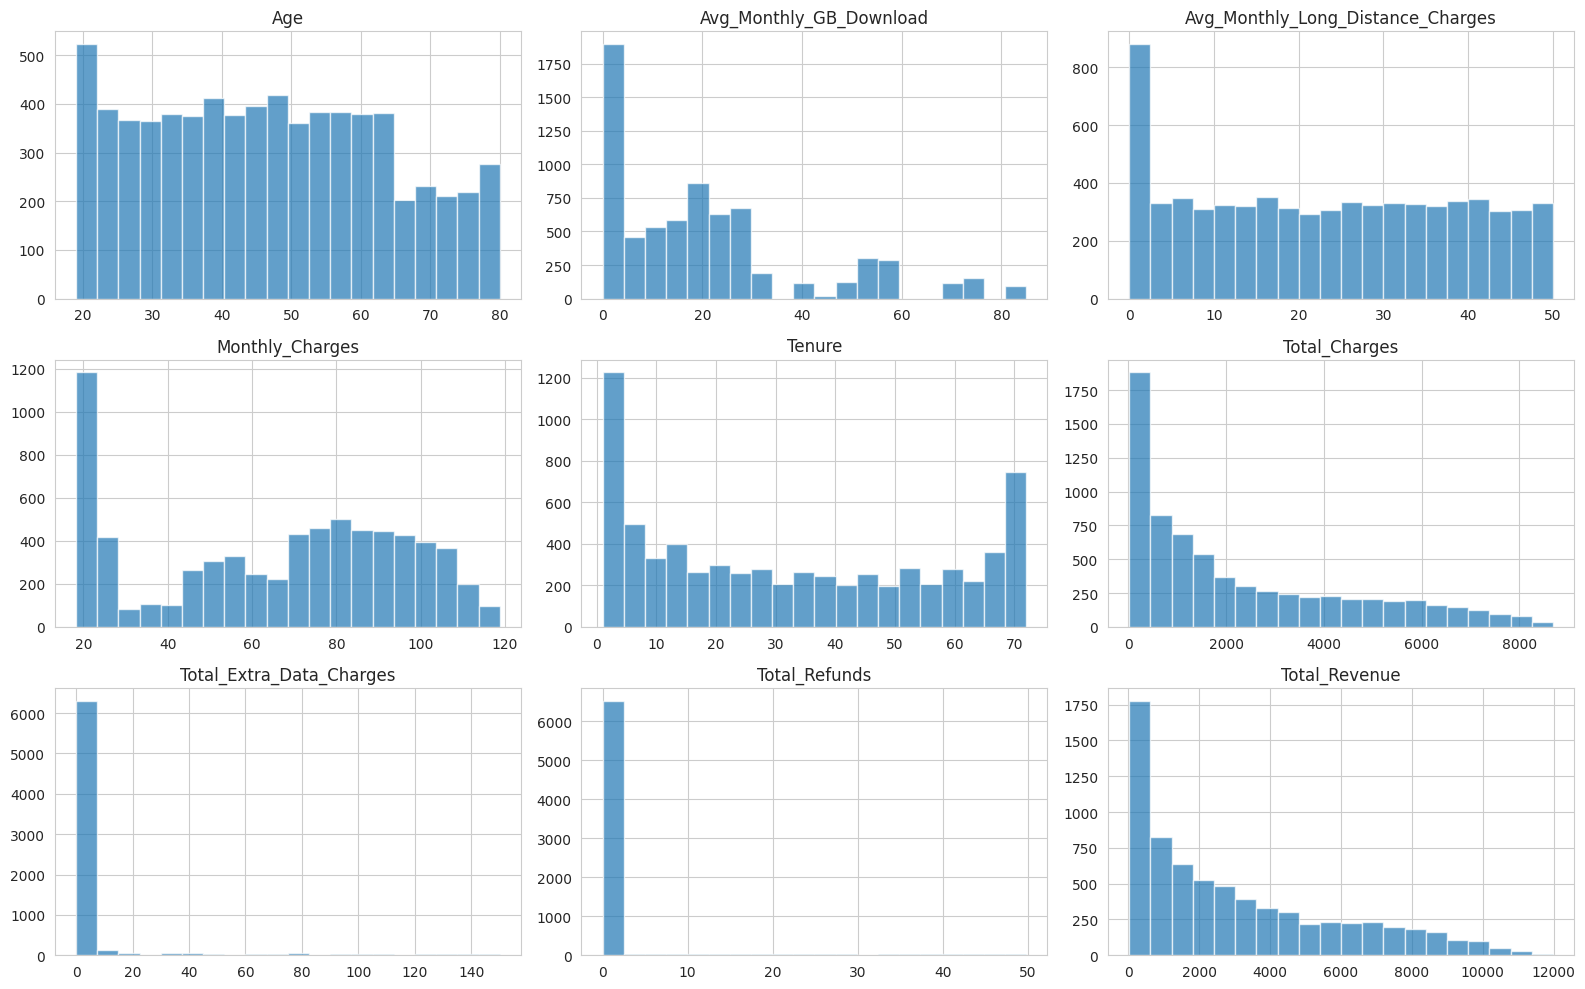

In [ ]:
# Variables that we are checking ditribution of
variables_to_check = [
  'Age',
  'Avg_Monthly_GB_Download',
  'Avg_Monthly_Long_Distance_Charges',
  'Monthly_Charges',
  'Tenure',
  'Total_Charges',
  'Total_Extra_Data_Charges',
  'Total_Refunds',
  'Total_Revenue'
]

# Create plot
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
axes = axes.flatten()

for i, var in enumerate(variables_to_check):
  axes[i].hist(df[var], bins=20, alpha=0.7, label=var)
  axes[i].set_title(var)

plt.tight_layout()
plt.show()

They all looked pretty evenly distributed or like they come from a natural place.

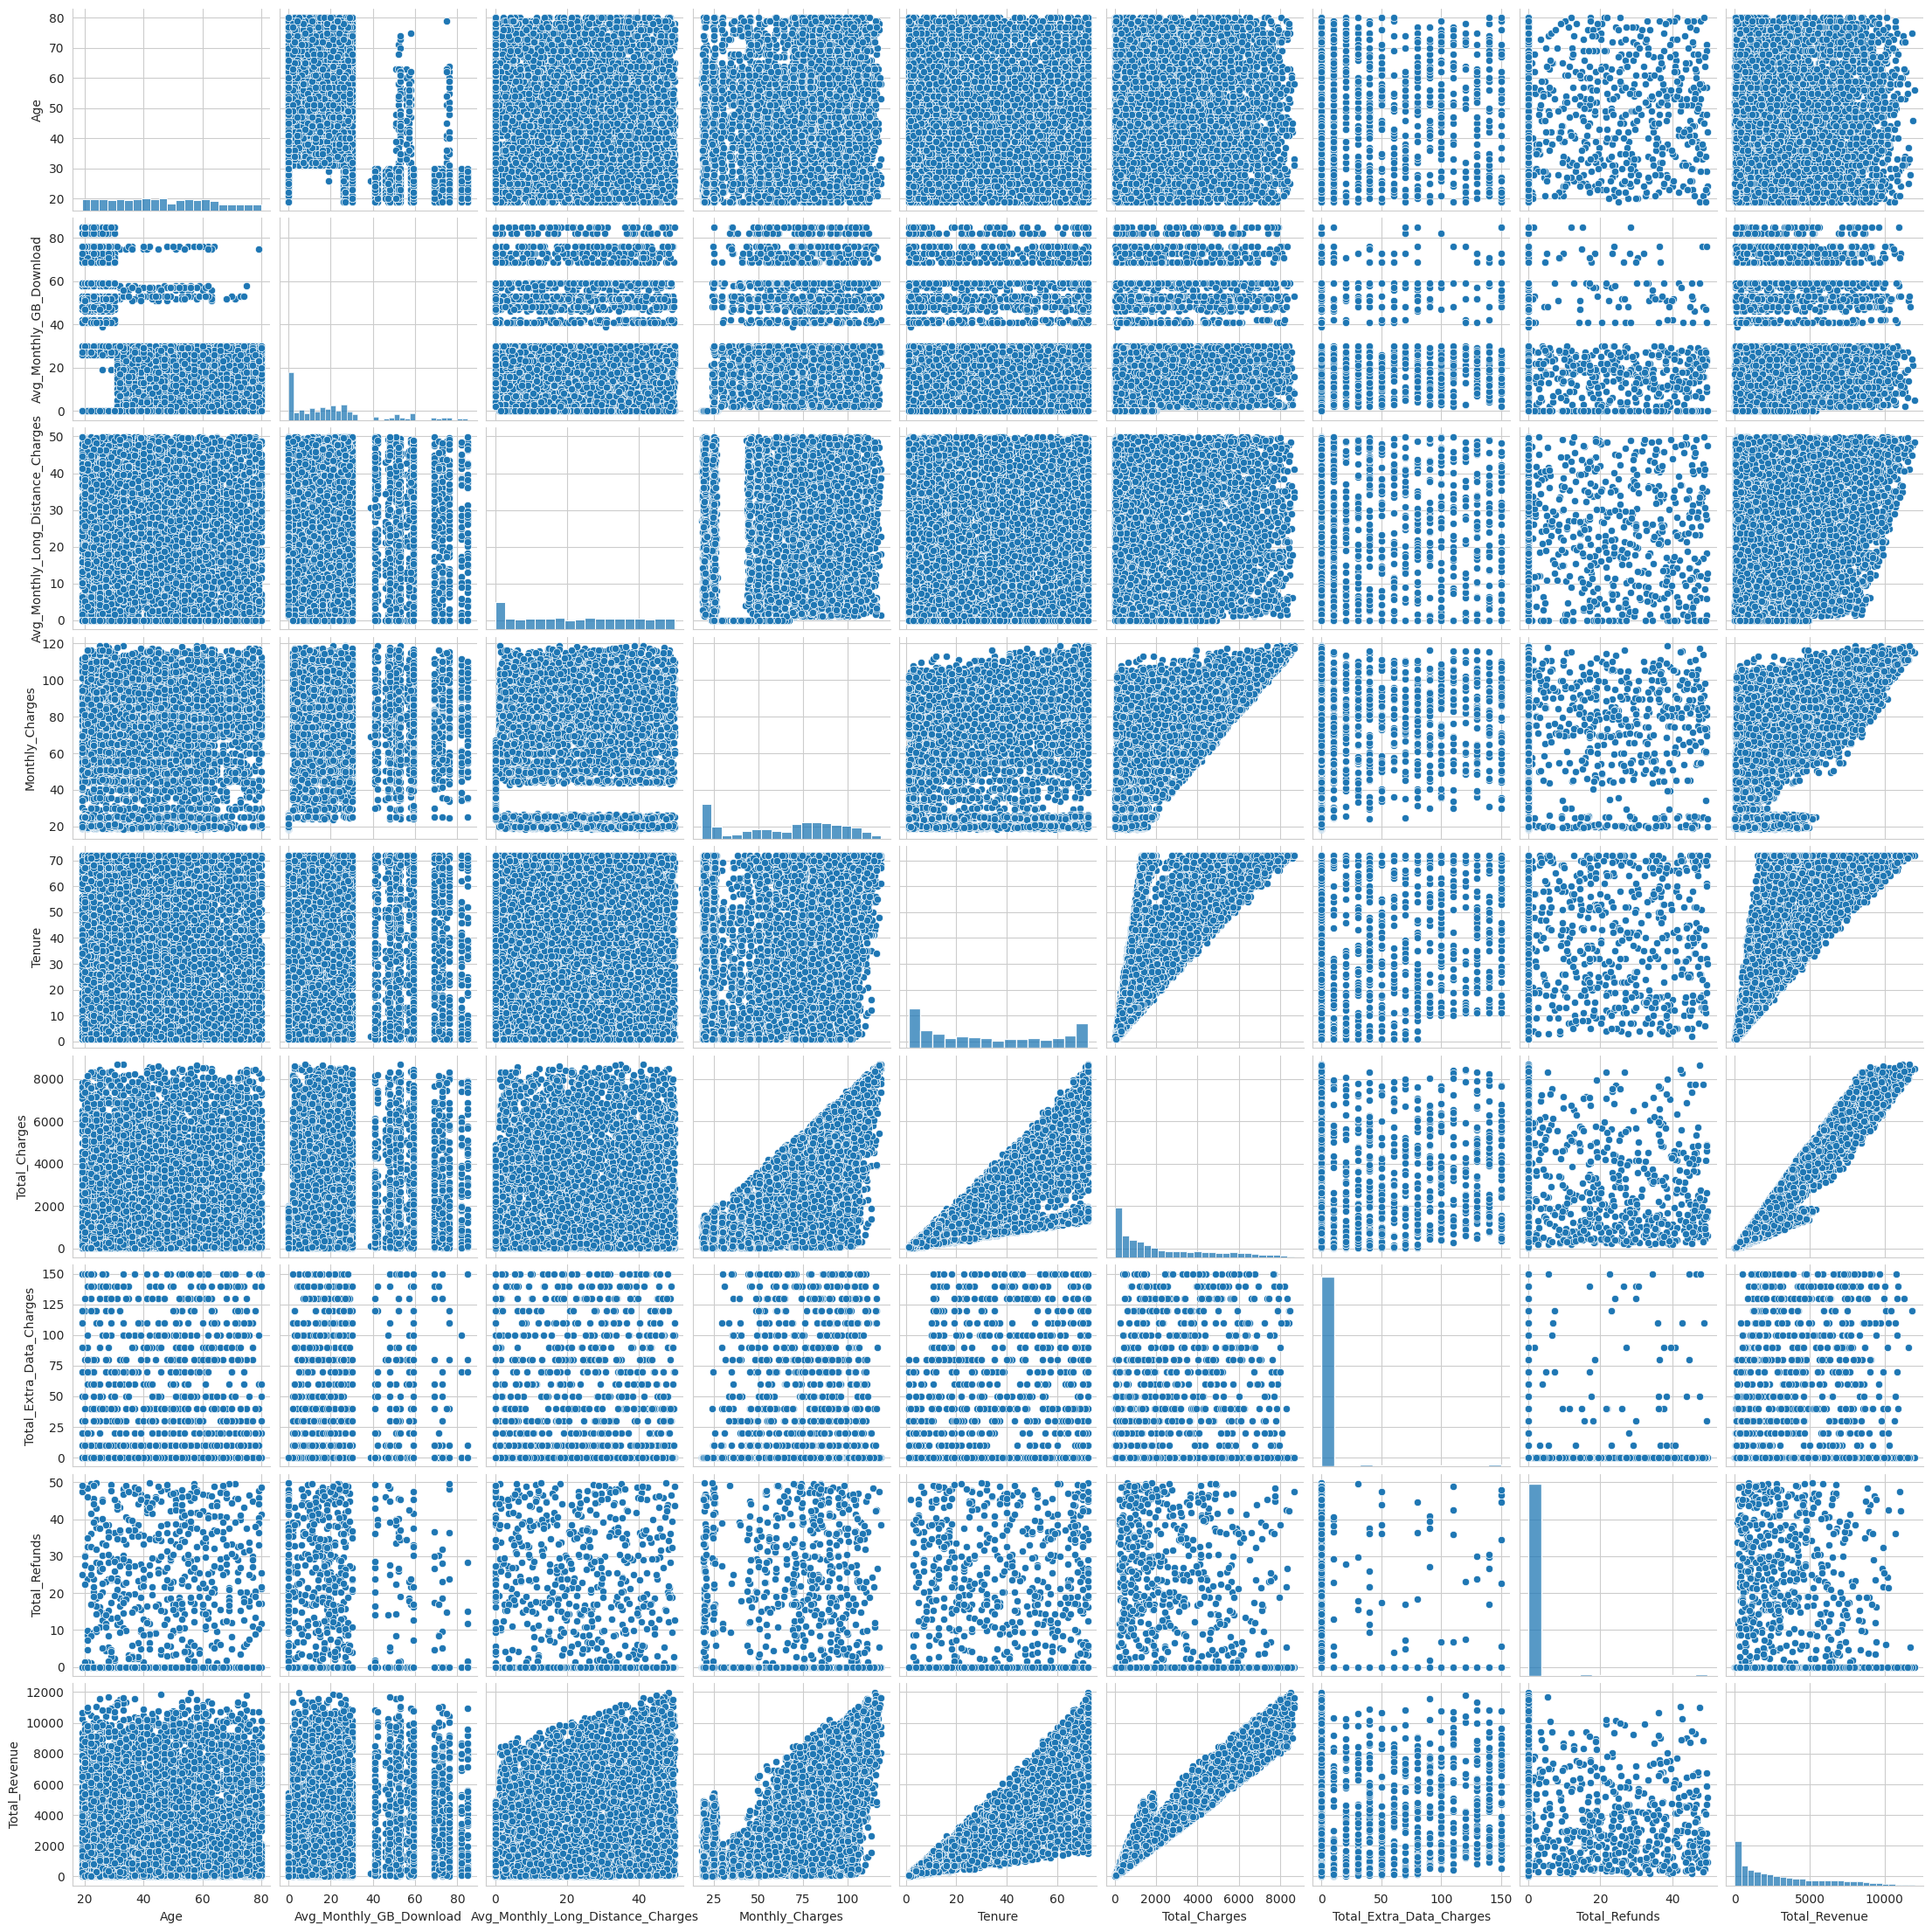

In [ ]:
# Pairplot
sns.pairplot(df, vars=variables_to_check)
plt.show()

After analyzing the pairplots, we decided not to remove any outliers from the dataset. Although some data points appear to deviate significantly from the majority (such as high revenue or extra data charges), these observations likely represent real customer behaviors rather than data errors. For instance, high revenue values may correspond to premium or long-term customers, while high data charges could indicate users with intensive data usage patterns. Removing these valid data points could distort the model's ability to capture diverse customer segments and reduce the accuracy of predictions. Therefore, we chose to retain the outliers to preserve the dataset's richness and variability.










### Outliers

We still decided to do outlier detection, just to be sure

In [ ]:
outlier_summary = {}

# Only select numeric columns
for col in df.select_dtypes(include=['float64', 'int64']):
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
  outlier_summary[col] = len(outliers)

# Show summary of outlier counts
outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier Count'])
outlier_df = outlier_df.sort_values('Outlier Count', ascending=False)
print(outlier_df)

                                   Outlier Count
Senior_Citizen                              1142
Total_Extra_Data_Charges                     728
Phone_Service                                680
Total_Refunds                                525
Avg_Monthly_GB_Download                      362
Total_Long_Distance_Charges                  194
Total_Revenue                                 21
Dependents                                     0
Online_Backup                                  0
Device_Protection                              0
Tech_Support                                   0
Partner                                        0
Tenure                                         0
Multiple_Lines                                 0
Internet_Service                               0
Online_Security                                0
Payment_Method                                 0
Paperless_Billing                              0
Contract                                       0
Streaming_Movies    

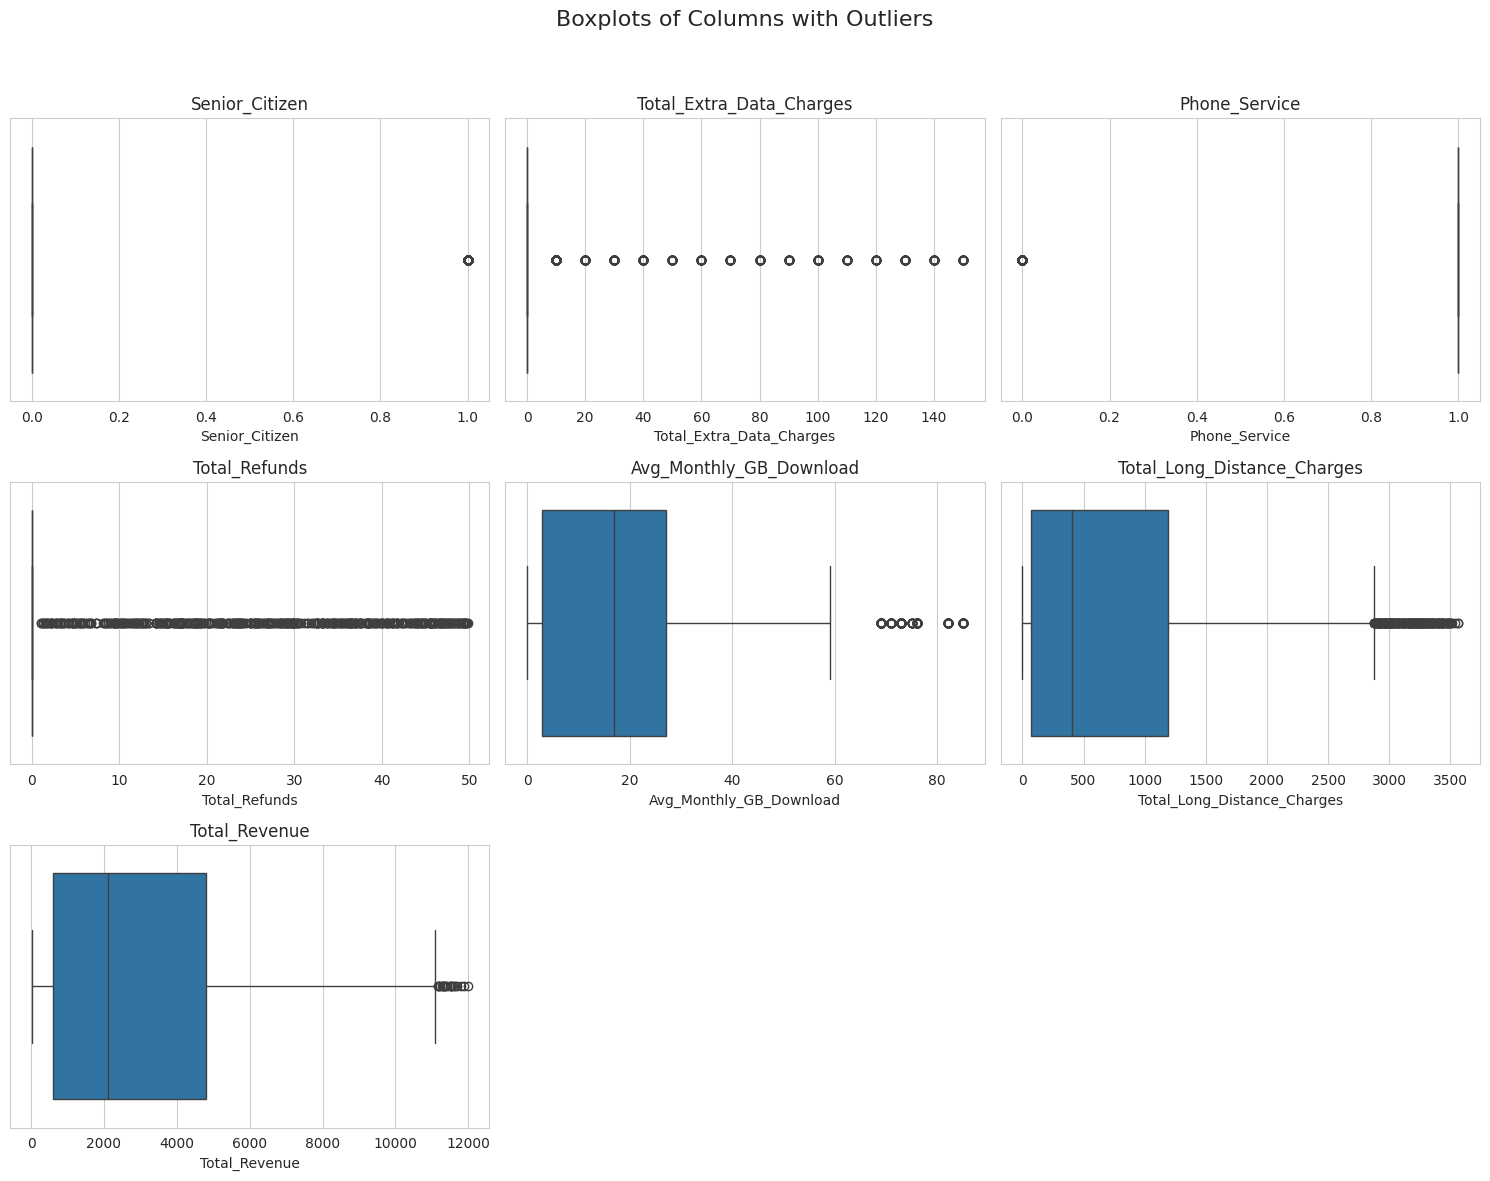

In [ ]:
# Get only columns with outliers
outlier_cols = outlier_df[outlier_df['Outlier Count'] > 0].index.tolist()

# Set up subplot grid
n = len(outlier_cols)
cols = 3  # Number of plots per row
rows = (n + cols - 1) // cols  # Calculate number of rows needed

plt.figure(figsize=(cols * 5, rows * 4))  # Adjust figure size

for i, col in enumerate(outlier_cols):
  plt.subplot(rows, cols, i + 1)
  sns.boxplot(x=df[col])
  plt.title(f'{col}')
  plt.tight_layout()

plt.suptitle('Boxplots of Columns with Outliers', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust to fit suptitle
plt.show()


Here we can see the columns that had an outlier count greater than zero, according to the IQR method. All of these outliers appear to represent natural variations in customer behavior rather than data errors.

## 2.5 Correlation

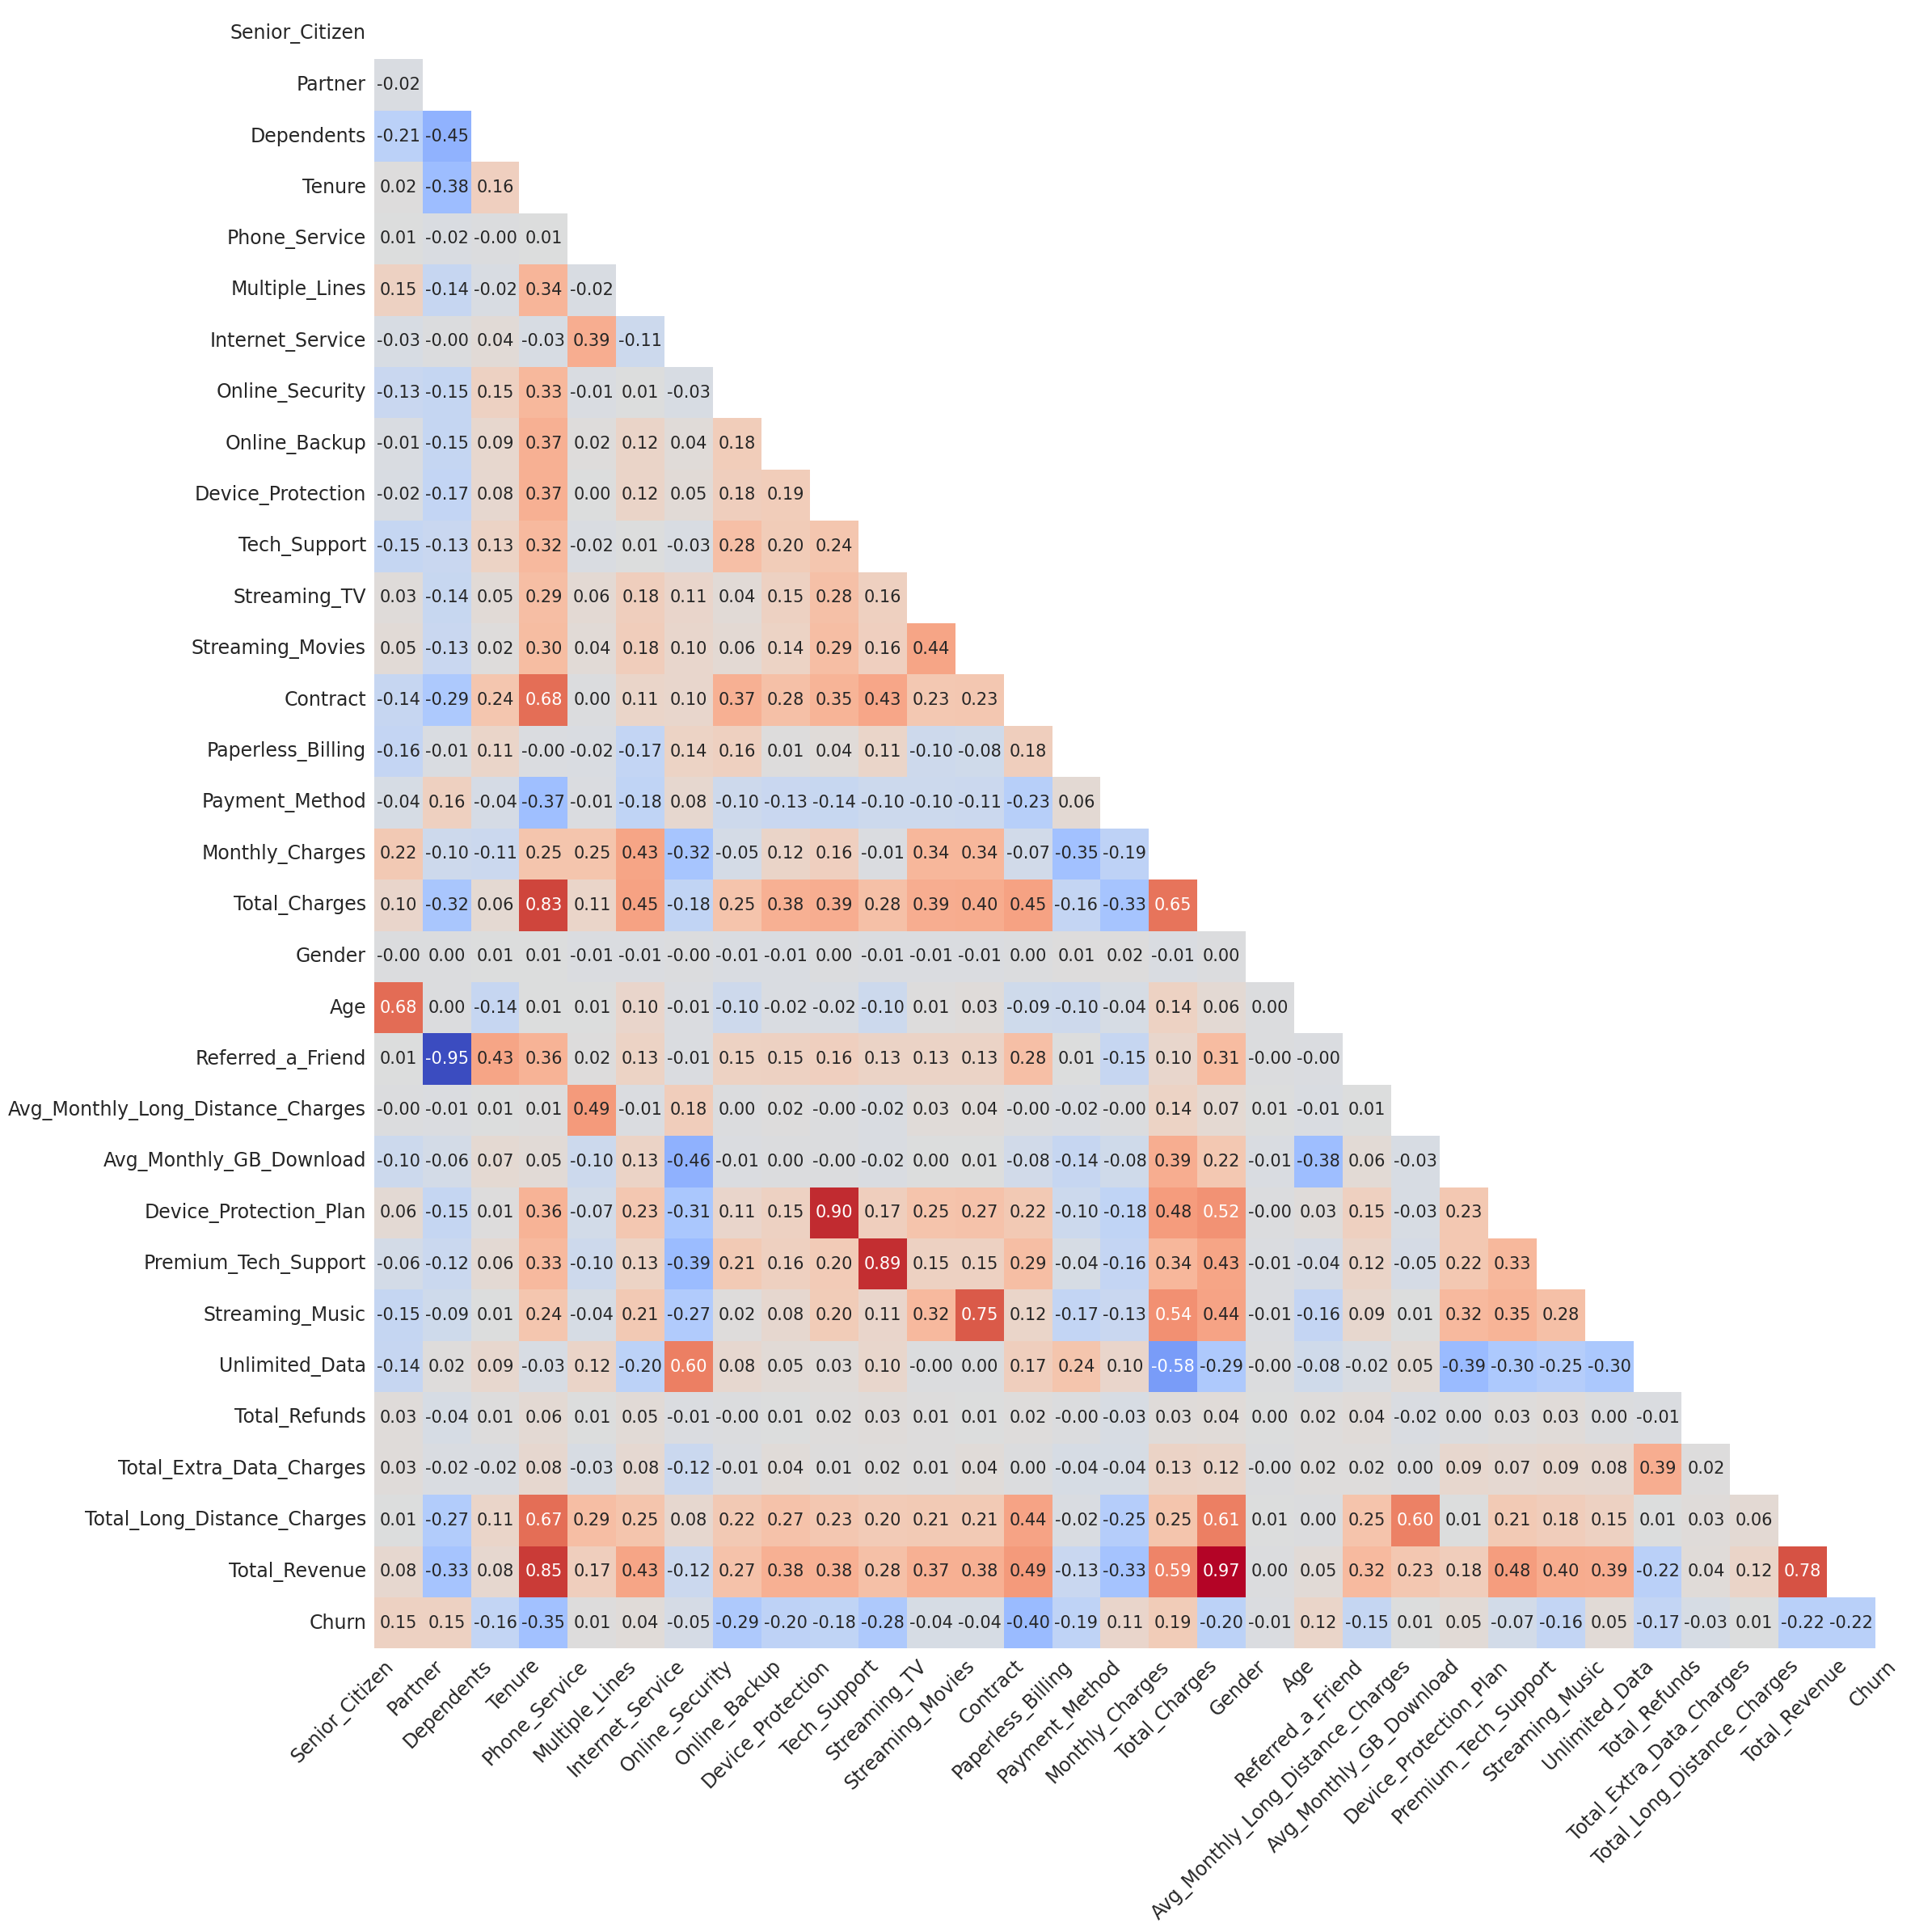

In [ ]:
df['Churn'] = df['Churn'].astype(int)

# Set style
sns.set_style('white')

# Select numeric features
numerical_features = df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix_full = numerical_features.corr()

# Move 'Churn' to the bottom-right
cols = [col for col in corr_matrix_full.columns if col != 'Churn'] + ['Churn']
corr_matrix_full = corr_matrix_full.loc[cols, cols]

# Mask upper triangle
mask_full = np.triu(np.ones_like(corr_matrix_full, dtype=bool))

# Plot with large boxes, small text
plt.figure(figsize=(24, 24))  # Bigger = bigger boxes
sns.heatmap(corr_matrix_full, annot=True, mask=mask_full,
            cmap='coolwarm', fmt='.2f', annot_kws={'size': 15}, cbar=False)
plt.xticks(rotation=45, ha='right', fontsize=17)
plt.yticks(rotation=0, fontsize=17)
plt.tight_layout()
plt.show()

To make the correlation matrix more interpretable, we decided to create a version that includes only the features with a correlation greater than 0.2 with the target variable, Churn. This approach helps us focus on the most relevant variables, reducing complexity while highlighting the strongest relationships.

However, it is important to note that even if a feature shows a weak correlation with the target, it can still hold predictive value for several reasons. Some features may not individually correlate strongly with churn, but their interactions with other variables can significantly impact predictions. And some features may have non-linear patterns with churn that correlation coefficients do not detect.

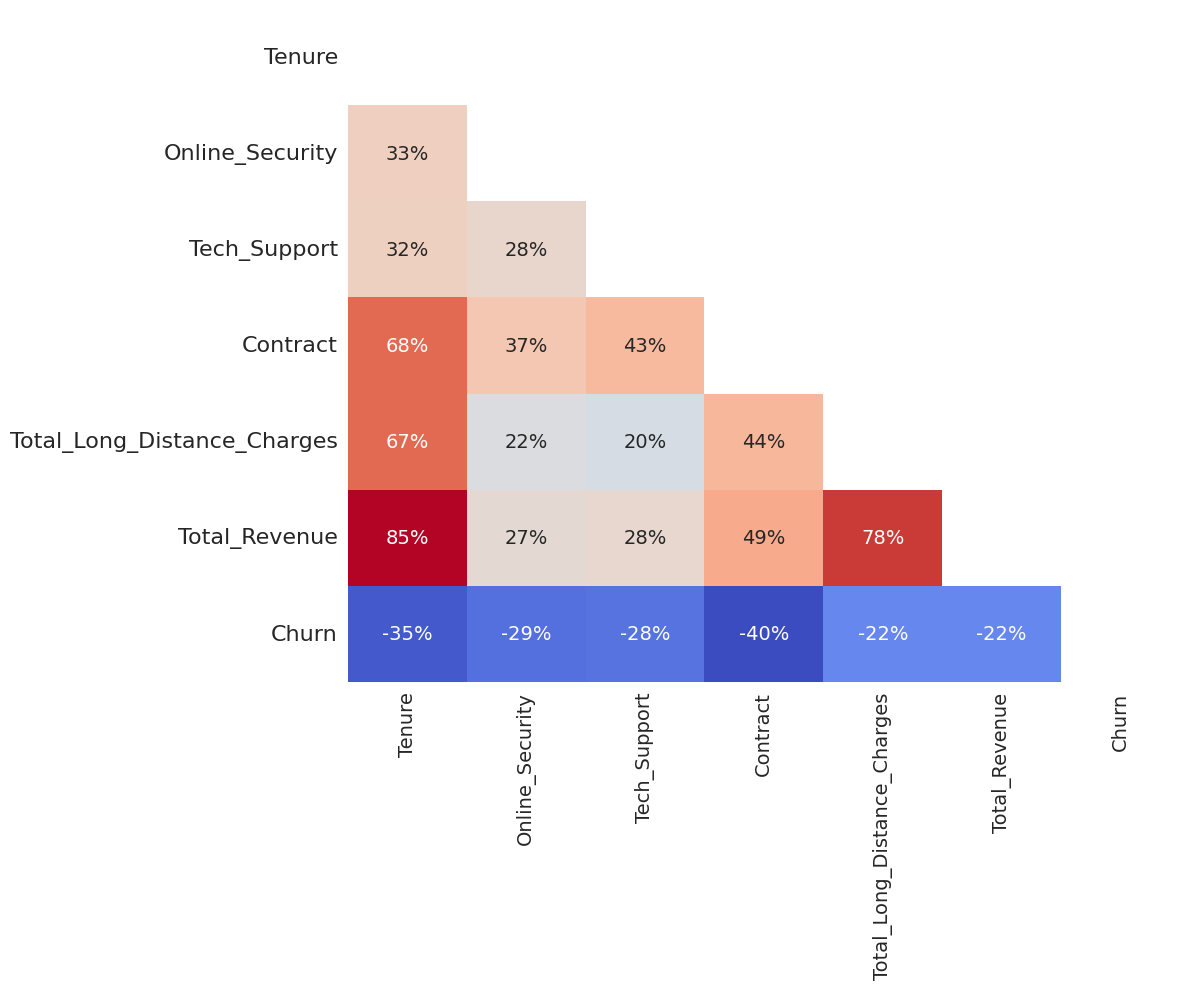

In [ ]:
# Select numeric features again (including the fixed 'Churn')
numerical_features = df.select_dtypes(include=[np.number])

# Compute full correlation matrix
corr_matrix_full = numerical_features.corr()

churn_corr = corr_matrix_full['Churn']  # Extract correlations with 'Churn'
focused_features = churn_corr[abs(churn_corr) > 0.2].index.tolist()

# Reorder so 'Churn' is at the end (bottom-right of heatmap)
if 'Churn' in focused_features:
  focused_features = [f for f in focused_features if f != 'Churn'] + ['Churn']

# Build focused matrix
corr_matrix_focused = corr_matrix_full.loc[focused_features, focused_features]

# Plot upper-triangle heatmap
mask_focused = np.triu(np.ones((len(focused_features), len(focused_features)), dtype=bool))

plt.figure(figsize=(12, 10))
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=16, rotation=0)
sns.heatmap(corr_matrix_focused, annot=True, mask=mask_focused,
            cmap='coolwarm', fmt='.0%', annot_kws={'size': 14}, cbar=False)
plt.tight_layout()
plt.show()


<ipython-input-106-07c2aa2f7af6>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_corr.values, y=churn_corr.index, palette='coolwarm')


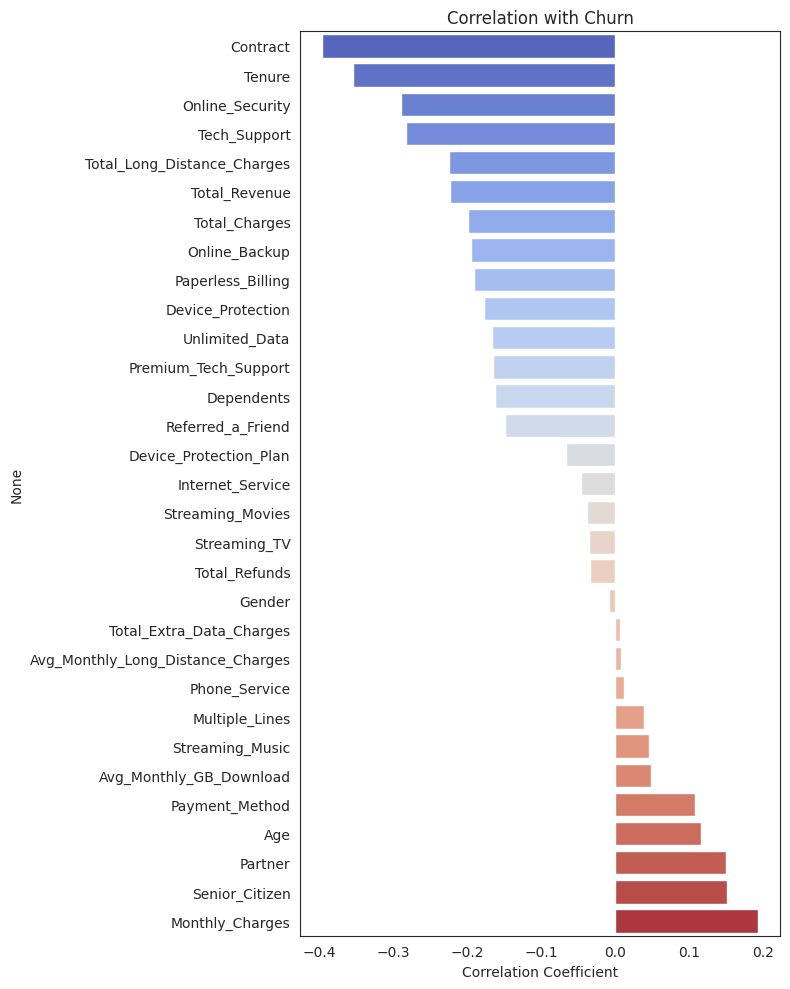

In [ ]:
# Style
sns.set_style('white')

# Select numeric features
numeric_features = df.select_dtypes(include=[np.number, bool])

# Compute correlation with 'Churn'
churn_corr = numeric_features.corr()['Churn'].drop('Churn').sort_values()

# Plot correlation with 'Churn'
plt.figure(figsize=(8, 10))
sns.barplot(x=churn_corr.values, y=churn_corr.index, palette='coolwarm')
plt.title('Correlation with Churn')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

Once more we can see that most of the features correlate negativly with the target.

# 3 Train-Test Split

## 3.1 Spilt and Check Distribution of Features

The Customer_ID column was dropped from the DataFrame because it contains unique values for each row. Unique identifiers do not contribute to model learning as they do not provide any predictive power. Therefore, removing them helps reduce unnecessary features.

In [ ]:
df = df.drop(columns=['Customer_ID'])

Before we can run any machine learning model we must split the data into train and test dataset

In [ ]:
# Defining features X and target variables y
# Drop the target column from the dataset
X = df.drop('Churn', axis=1)
# Extract the target variable
y = df['Churn']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Confirming the successful data split by displaying the shape of each set
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((5625, 31), (1407, 31), (5625,), (1407,))

After spliting, we check if our target value is equally distribution in the test and train dataset

In [ ]:
# Check the distribution of the target variable in the training and testing sets
distribution_train = y_train.value_counts(normalize=True)
distribution_test = y_test.value_counts(normalize=True)

distribution_train, distribution_test

(Churn
 0   0.73
 1   0.27
 Name: proportion, dtype: float64,
 Churn
 0   0.73
 1   0.27
 Name: proportion, dtype: float64)

It looks pretty similar with out test dataset, having a slightly higher number of Churns

In [ ]:
# Calculate mean and standard deviation of features for both training and testing sets
mean_std_train = X_train.describe().loc[['mean', 'std']]
mean_std_test = X_test.describe().loc[['mean', 'std']]

# Create dataframes to compare mean values between training and testing sets
mean_comparison = pd.DataFrame({
    'Train Mean': mean_std_train.loc['mean'],
    'Test Mean': mean_std_test.loc['mean']
})

# Compare standard deviation values between train and test sets
std_comparison = pd.DataFrame({
    'Train Std': mean_std_train.loc['std'],
    'Test Std': mean_std_test.loc['std']
})

# Calculating differences, for both mean and Standard Deviation
mean_difference = mean_std_train.loc['mean'] - mean_std_test.loc['mean']
std_difference = mean_std_train.loc['std'] - mean_std_test.loc['std']

# Add difference to mean comparison, to more easy spot any abonormalities
mean_comparison = pd.DataFrame({
  'Train Mean': mean_std_train.loc['mean'],
  'Test Mean': mean_std_test.loc['mean'],
  'Difference': mean_difference
})

# Add difference to standard deviation comparison dataframe
std_comparison = pd.DataFrame({
  'Train Std': mean_std_train.loc['std'],
  'Test Std': mean_std_test.loc['std'],
  'Difference': std_difference
})

mean_comparison, std_comparison

(                                   Train Mean  Test Mean  Difference
 Senior_Citizen                           0.16       0.17       -0.01
 Partner                                  0.52       0.51        0.01
 Dependents                               0.30       0.29        0.00
 Tenure                                  32.34      32.77       -0.43
 Phone_Service                            0.90       0.91       -0.00
 Multiple_Lines                           0.93       0.98       -0.05
 Internet_Service                         0.88       0.85        0.03
 Online_Security                          0.79       0.77        0.02
 Online_Backup                            0.91       0.88        0.03
 Device_Protection                        0.90       0.90        0.00
 Tech_Support                             0.80       0.79        0.01
 Streaming_TV                             0.99       0.96        0.03
 Streaming_Movies                         1.00       0.96        0.04
 Contract           

Here we can see that it looks very evenly distributed across all features

To be extra sure we can also test if the most important features for the dataset are consistent between the training and testing sets. We can do this by using a simple, non-tuned RandomForestClassifier. This will help verify that the features likely to be most important in various machine learning models are similar across both the training and testing data.

In [ ]:
# Initialize and training the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Extract feature importance scores
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to display feature importance
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Show the top 10 most important features
feature_importances_df.head(10)

Feature  Importance
16                    Monthly_Charges        0.10
30                      Total_Revenue        0.09
3                              Tenure        0.08
17                      Total_Charges        0.08
13                           Contract        0.07
29        Total_Long_Distance_Charges        0.07
19                                Age        0.07
21  Avg_Monthly_Long_Distance_Charges        0.07
22            Avg_Monthly_GB_Download        0.06
7                     Online_Security        0.04

Now we have the most important

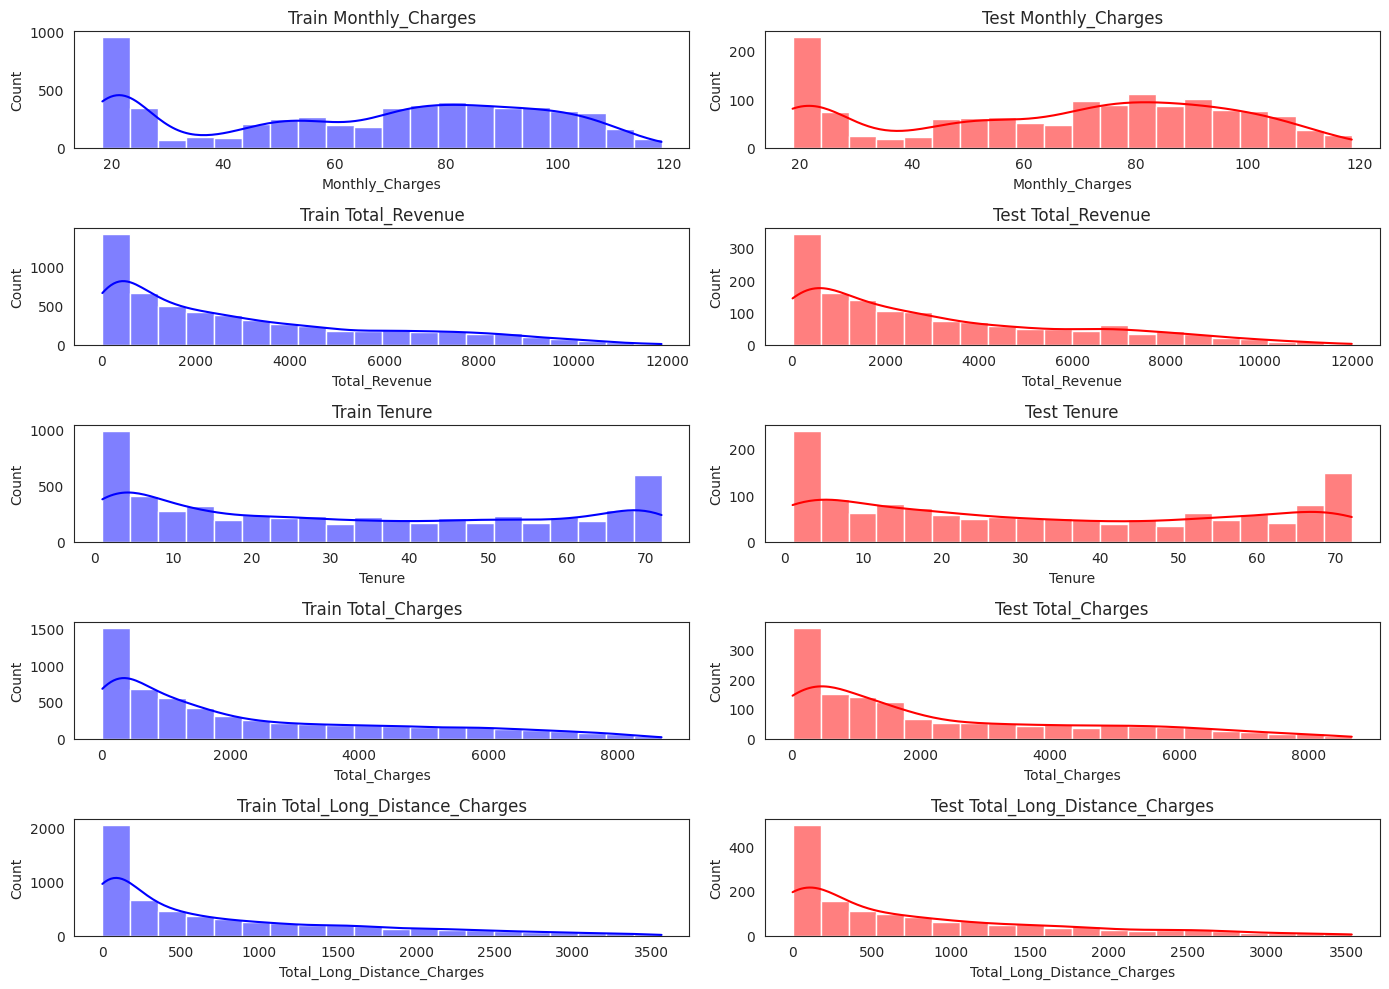

In [ ]:
# Select the most important features, found using Random Forest Classifier
important_features = ["Monthly_Charges","Total_Revenue", "Tenure",
                      "Total_Charges","Total_Long_Distance_Charges"]

# Set the plot size
plt.figure(figsize=(14, 10))

for i, feature in enumerate(important_features):
  # Plot training data distribution
  plt.subplot(len(important_features), 2, 2*i+1)
  sns.histplot(X_train[feature], color='blue', kde=True, bins=20)
  plt.title(f'Train {feature}')

  # Plot testing data distribution
  plt.subplot(len(important_features), 2, 2*i+2)
  sns.histplot(X_test[feature], color='red', kde=True, bins=20)
  plt.title(f'Test {feature}')

plt.tight_layout()
plt.show()

## 3.2 Resampling Methods

Since we have class imbalance in our dataset, with a 3:1 imbalance (5,174 non-churned vs. 1,869 churned), we decided to check if we could enhance the performance of our models by using different sampling methods.

We will test both under and oversampling methods.

We will test each sampling method agains a baseline model which will be the decicion tree classifier, non-tuned. This is to check if the resampled datasets perform better than our original.  

Even though we saw a slightly better performance with the undersampling dataset, we decided not to use it. We have elaborated on the why in our report.

In [ ]:
# Applying ADASYN to our Training dataset
adasyn = ADASYN(random_state=42)
X_train, y_train = adasyn.fit_resample(X_train, y_train)

print(f'Original dataset shape: {(5625, 31), (5625,)}')
print(f'Resampled dataset shape: {X_train.shape, y_train.shape}')

Original dataset shape: ((5625, 31), (5625,))
Resampled dataset shape: ((8103, 31), (8103,))


In [ ]:
# Compare the target variable distribution between resampled training set and testing sets
distribution_train = y_train.value_counts(normalize=True)
distribution_test = y_test.value_counts(normalize=True)

distribution_train, distribution_test

(Churn
 0   0.51
 1   0.49
 Name: proportion, dtype: float64,
 Churn
 0   0.73
 1   0.27
 Name: proportion, dtype: float64)

Testing some more to see if we skewed the most imporant features

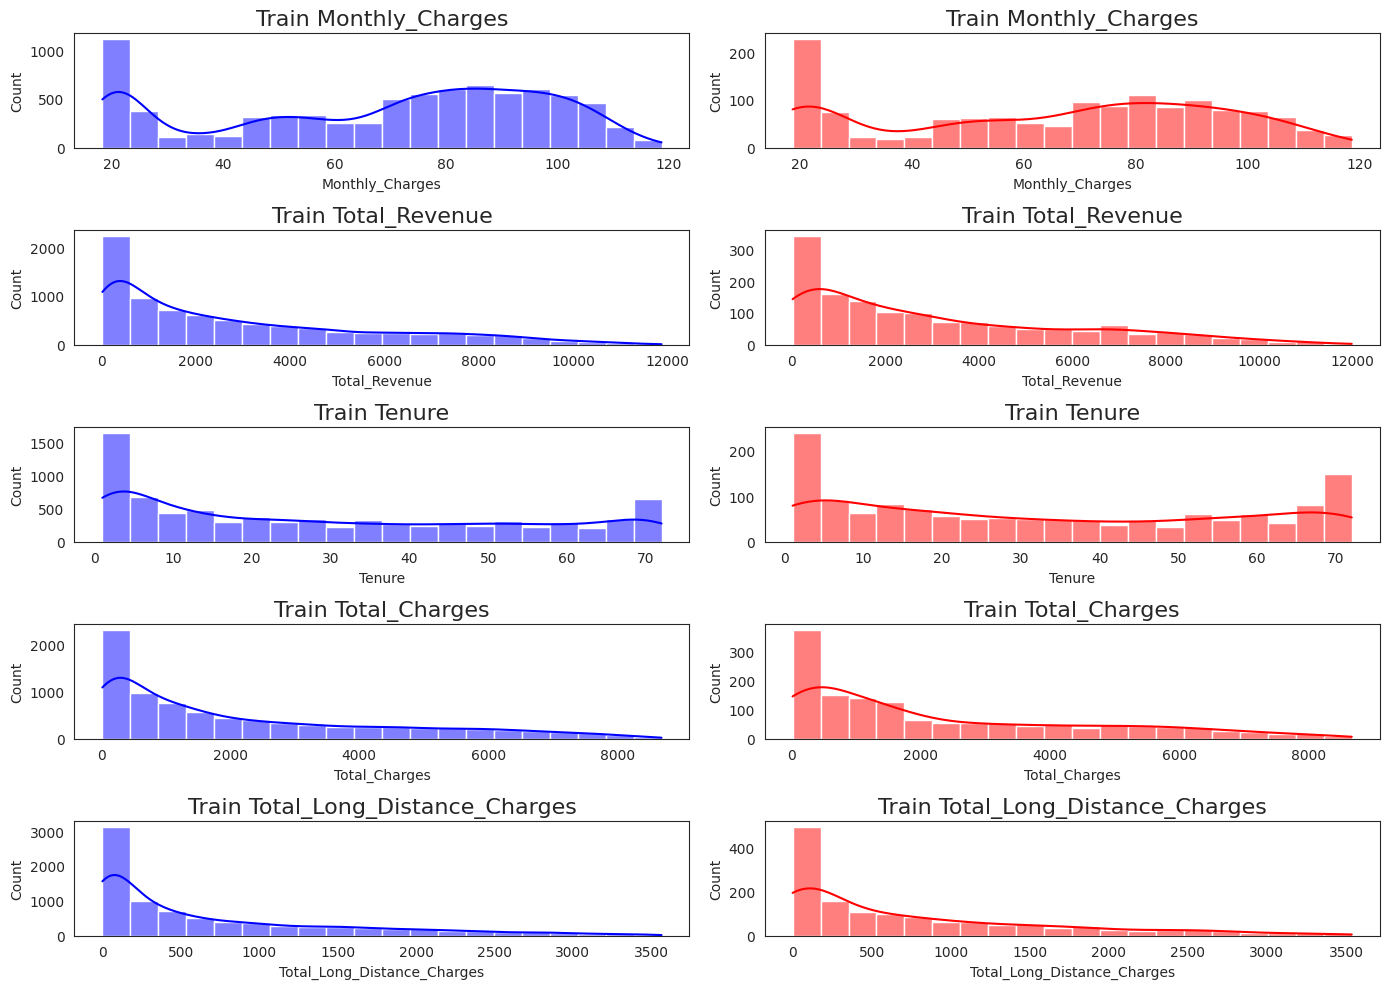

In [ ]:
# Select the most important features, found using Random Forest Classifier
important_features = ["Monthly_Charges","Total_Revenue", "Tenure",
                      "Total_Charges","Total_Long_Distance_Charges"]

# Plot the figure size
plt.figure(figsize=(14, 10))

for i, feature in enumerate(important_features):
  # Plot for training data Distribution
  plt.subplot(len(important_features), 2, 2*i+1)
  sns.histplot(X_train[feature], color='blue', kde=True, bins=20)
  plt.title(f'Train {feature}', fontsize=16)

  # Plot for testing data distribution
  plt.subplot(len(important_features), 2, 2*i+2)
  sns.histplot(X_test[feature], color='red', kde=True, bins=20)
  plt.title(f'Train {feature}', fontsize=16)

plt.tight_layout()
plt.show()

As we can see, applying ADASYN did not noticbly skew our training dataset compared to the test dataset.

# 4. Building our ML Models

## 4.1 Defining Functions to be used later

In this section, we are evaluating three different machine learning models to assess their effectiveness in predicting churn. We will tailor the training process for each model according to its specific requirements to ensure optimal performance. Our primary optimization metric is the area under the curve (AUC), which provides a comprehensive measure of model accuracy by accounting for both sensitivity and specificity.

For each model, we start by building a default version, which serves as our baseline. This baseline model helps us establish a minimum performance level. If any tuned model performs worse than the baseline, it indicates that we may have misjudged the tuning process or made a mistake in our approach. By setting a minimum AUC threshold with the default model, we gain a clear reference point to assess improvements. This allows us to quantify how much performance can be enhanced through feature engineering and hyperparameter optimization.

For each model, we create a 'study' using the Optuna framework, where we perform cross-validation on the training data within the study. To streamline the process and adhere to the "Don't Repeat Yourself" (DRY) principle, we first develop reusable functions to handle any logic that will be applied multiple times. This approach not only minimizes code redundancy but also enhances efficiency and consistency across model evaluations. By setting up these functions upfront, we ensure a more organized and modular workflow when building and optimizing our models.










In [ ]:
# Generate baseline model and calculate AUC
def get_baseline(model):
  model.fit(X_train, y_train)

  # Predict probabilities for the test set
  y_proba = model.predict_proba(X_test)[:, 1]

  # Calculate AUC Score
  auc_score = roc_auc_score(y_test, y_proba)
  print(f'Baseline AUC: {auc_score:.4f}')

To ensure reproducibility during hyperparameter tuning, we set a fixed seed for the sampler within the Optuna framework. This guarantees consistent results across different runs, allowing us to accurately assess model performance. Additionally, we suppress unnecessary logging to keep the output clean and focused.

To streamline the tuning process, we create a general function to return hyperparameters. This function encapsulates the logic needed to define and optimize hyperparameters, making the tuning process more modular and easily adaptable for different models. By combining seed setting, logging management, and function modularity, we maintain an efficient and repeatable workflow for hyperparameter optimization.

In [ ]:
# Set seed for reproducibility and to remove logs
sampler = optuna.samplers.TPESampler(seed=42)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Run hyperparameter optimization and return the best parameters
def optimize_study(objective, n_trials):
  study = optuna.create_study(direction='maximize', sampler=sampler)
  study.optimize(objective, n_trials=n_trials)
  params = study.best_params
  return params

In [ ]:
# Extract columns and hyperparameters based on inclusion criteria
def columns_keep(params, X_train = X_train, X_test = X_test):
  # Finding all features with value marked for inclusion
  column_params = {key: value for key, value in params.items() if key.startswith('include_') and value}

  # Create a list of columns to keep, removing the 'include_' prefix
  columns_to_keep = [key[len('include_'):] for key, value in column_params.items() if value]

  # Subset the training and testing data with selected columns
  X_train_temp = X_train[columns_to_keep]
  X_test_temp = X_test[columns_to_keep]

  # Exclude column-related parameters
  params_excluding_features = {key: value for key, value in params.items() if not key.startswith('include_')}

  return X_train_temp, X_test_temp, params_excluding_features


In [ ]:
# Extract and display feature importance
def extract_importance(model, X_train):
  # Get important variables
  importances = model.feature_importances_

  # Get the feature names
  feature_names = np.array(X_train.columns)

  # Sort the features by importance
  sorted_idx = np.argsort(importances)[::-1]

  # Display sorted features with their importance scores
  print('Features sorted by importance:')
  for index in sorted_idx:
    print(f'{feature_names[index]}: {importances[index]:.4f}')

Defining the function to visualize and present the results of the tuning

In [ ]:
# Getting the Classification Report and Confusion Matrix
def get_classification_report_and_cm(X_train, X_test, model):
  # Train the model
  model.fit(X_train, y_train)

  # Getting AUC score
  y_pred_proba = model.predict_proba(X_test)[:, 1]

  auc_score = roc_auc_score(y_test, y_pred_proba)

  # Print AUC Score
  print(f'AUC Score: {auc_score}')

  # Predict churn for confusion matrix and ROC curve
  y_pred = model.predict(X_test)

  # Plot the ROC curve
  fpr, tpr = roc_curve(y_test, y_pred_proba)[:2]
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc='lower right', fontsize=20)
  plt.show()

  # Predict churn for metrics calculation
  pred = model.predict(X_test)

  # Generate and print the classification report
  print("\n" + "="*40)
  print("       Classification Report")
  print("="*40)
  print(classification_report(y_test, y_pred))
  print("="*40 + "\n")

  # Generate the confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  # Plot the confusion matrix using the preferred style
  plt.figure(figsize=(8, 6))
  ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, annot_kws={'size': 24})

  # Set label fonts and titles
  label_font = {'size': '14'}
  ax.set_xlabel('Predicted labels', fontdict=label_font)
  ax.set_ylabel('Observed labels', fontdict=label_font)

  title_font = {'size': '18'}
  ax.set_title('Confusion Matrix', fontdict=title_font)

  # Customize tick labels
  ax.tick_params(axis='both', which='major', labelsize=12)
  ax.xaxis.set_ticklabels(['Non-Churn', 'Churn'])
  ax.yaxis.set_ticklabels(['Non-Churn', 'Churn'])
  plt.show()

Used at the end of the code, to visualize settning a custom threshold

In [ ]:
# Custom threshold evaluation function
def evaluate_with_custom_threshold(y_test, y_pred_proba, threshold=0.5):
    # Adjust predictions based on custom threshold
    y_pred_custom = (y_pred_proba >= threshold).astype(int)

    # Generate and print the classification report
    print("\n" + "="*40)
    print(f"Classification Report (Threshold = {threshold})")
    print("="*40)
    print(classification_report(y_test, y_pred_custom))
    print("="*40 + "\n")

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred_custom)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, annot_kws={'size': 20})

    # Set label fonts and titles
    label_font = {'size': 14}
    ax.set_xlabel('Predicted labels', fontdict=label_font)
    ax.set_ylabel('Observed labels', fontdict=label_font)

    title_font = {'size': 18}
    ax.set_title(f'Confusion Matrix (Threshold = {threshold})', fontdict=title_font)

    # Customize tick labels
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.xaxis.set_ticklabels(['Non-Churn', 'Churn'])
    ax.yaxis.set_ticklabels(['Non-Churn', 'Churn'])
    plt.show()

## 4.2 Deicsion Tree Classifier

In [ ]:
# Checking baseline
dt_default = DecisionTreeClassifier(random_state=42)
get_baseline(dt_default)

Baseline AUC: 0.6410


Given that decision trees often struggle with handling non-significant features, we have integrated feature selection into our hyperparameter tuning process. This strategy enables us to systematically identify and retain only the features that significantly enhance the model's performance, ensuring a more efficient and accurate model.

In [ ]:
def optimize_decision_tree(trial):
  # Dynamic feature inclusion/exclusion
  selected_features = []
  for feature in X_train.columns:
      # For each feature, decide if it should be included
      if trial.suggest_categorical(f'include_{feature}', [True, False]):
          selected_features.append(feature)

  # Subset the training to only include selected features
  X_train_selected = X_train[selected_features]

    # Define the hyperparameter space for other parameters
  params = {
      'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
      'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0001, 0.0020),
      'max_depth': trial.suggest_int('max_depth', 2, 32),
      'min_samples_split': trial.suggest_int('min_samples_split', 2, 64),
      'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 64),
    }

  # Create and train the model on the selected features
  model = DecisionTreeClassifier(random_state=42, **params)

  auc_scores = cross_val_score(model, X_train_selected, y_train, cv=10, scoring='roc_auc', n_jobs=-1)

  return auc_scores.mean()

In [ ]:
dectree_params = optimize_study(optimize_decision_tree, n_trials=10)
print(f'Best params for decision tree classifier: {dectree_params}')

Best params for decision tree classifier: {'include_Senior_Citizen': False, 'include_Partner': True, 'include_Dependents': False, 'include_Tenure': False, 'include_Phone_Service': True, 'include_Multiple_Lines': True, 'include_Internet_Service': True, 'include_Online_Security': True, 'include_Online_Backup': False, 'include_Device_Protection': True, 'include_Tech_Support': True, 'include_Streaming_TV': False, 'include_Streaming_Movies': True, 'include_Contract': True, 'include_Paperless_Billing': True, 'include_Payment_Method': False, 'include_Monthly_Charges': False, 'include_Total_Charges': False, 'include_Gender': True, 'include_Age': False, 'include_Referred_a_Friend': True, 'include_Avg_Monthly_Long_Distance_Charges': True, 'include_Avg_Monthly_GB_Download': True, 'include_Device_Protection_Plan': False, 'include_Premium_Tech_Support': True, 'include_Streaming_Music': True, 'include_Unlimited_Data': False, 'include_Total_Refunds': True, 'include_Total_Extra_Data_Charges': False, '

AUC Score: 0.7848874831108189


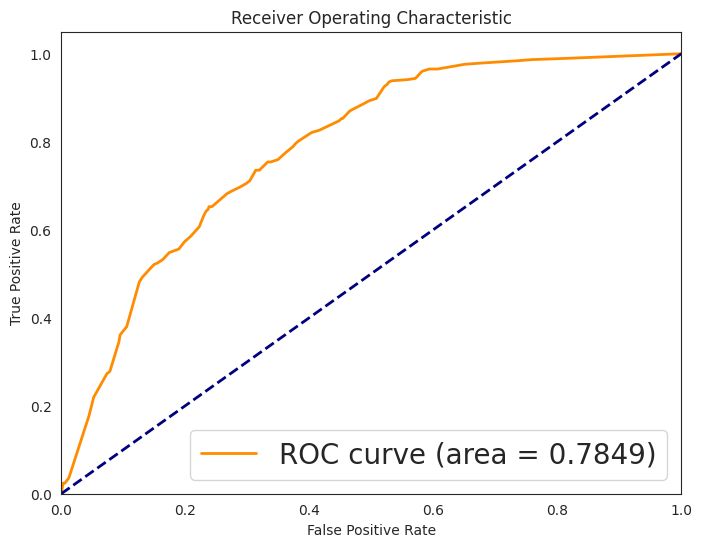


       Classification Report
              precision    recall  f1-score   support

           0       0.84      0.79      0.81      1033
           1       0.50      0.59      0.54       374

    accuracy                           0.74      1407
   macro avg       0.67      0.69      0.68      1407
weighted avg       0.75      0.74      0.74      1407




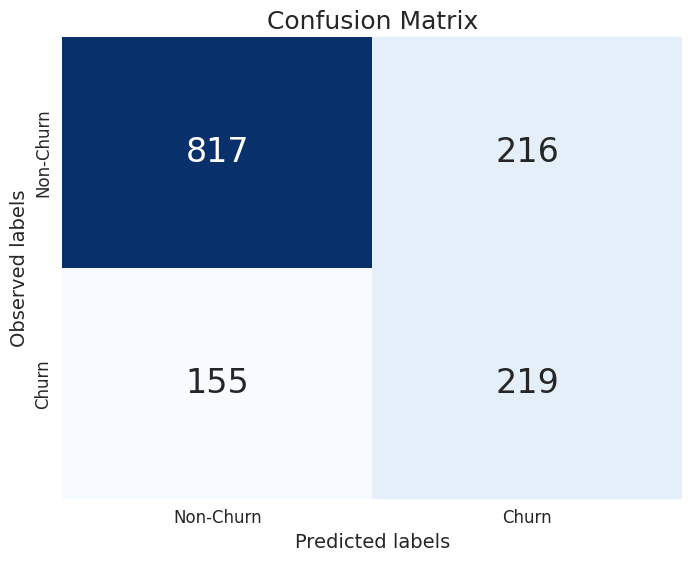

In [ ]:
# Create new datasets using the best features and hyperparameters for the Decision Tree
X_train_dectree, X_test_dectree, params_dectree = columns_keep(dectree_params)

# Train the Decision Tree model with optimized parameters
model_dectree = DecisionTreeClassifier(random_state=42, **params_dectree)

# Generate classification report and confusion matrix
get_classification_report_and_cm(
    X_train=X_train_dectree, X_test=X_test_dectree, model = model_dectree
)

The results clearly demonstrate the significant impact of hyperparameter tuning, with the AUC score improving by 0.14 compared to the baseline model.

However, to further enhance the model's performance, we plan to increase the number of trials to 500. By conducting more trials, we aim to achieve an even better AUC score.

In [ ]:
extract_importance(model_dectree, X_train_dectree)

Features sorted by importance:
Contract: 0.5340
Paperless_Billing: 0.0977
Online_Security: 0.0725
Tech_Support: 0.0671
Partner: 0.0479
Internet_Service: 0.0426
Referred_a_Friend: 0.0312
Avg_Monthly_GB_Download: 0.0261
Streaming_Movies: 0.0253
Gender: 0.0194
Avg_Monthly_Long_Distance_Charges: 0.0160
Device_Protection: 0.0114
Total_Refunds: 0.0051
Streaming_Music: 0.0020
Multiple_Lines: 0.0017
Premium_Tech_Support: 0.0000
Phone_Service: 0.0000


In [ ]:
try:
  # Placeholder exception to prevent accidental execution - remove to run the optimization
  raise Exception('Intentional exception: remove to execute optimization')
  # Run hyperparameter optimization for the Decision Tree
  best_dectree_params = optimize_study(optimize_decision_tree, n_trials=500)
  print(f'Best parameters for Decision Tree: {best_dectree_params}')
except Exception:
  print('Remove the intentional exception to execute optimization')

Remove the intentional exception to execute optimization


We hardcoded the answers from the block of code over, since it will take some time to compute (5 minutes, depending on your computer)

In [ ]:
# Best parameters obtained from 500 trials (precomputed for efficiency)
best_dectree_params = {'include_Senior_Citizen': False, 'include_Partner': True, 'include_Dependents': True,
                       'include_Tenure': False, 'include_Phone_Service': True, 'include_Multiple_Lines': False,
                       'include_Internet_Service': False, 'include_Online_Security': True, 'include_Online_Backup': True,
                       'include_Device_Protection': True, 'include_Tech_Support': True, 'include_Streaming_TV': True,
                       'include_Streaming_Movies': False, 'include_Contract': True, 'include_Paperless_Billing': False,
                       'include_Payment_Method': True, 'include_Monthly_Charges': False, 'include_Total_Charges': True,
                       'include_Gender': True, 'include_Age': False, 'include_Referred_a_Friend': True,
                       'include_Avg_Monthly_Long_Distance_Charges': False, 'include_Avg_Monthly_GB_Download': True,
                       'include_Device_Protection_Plan': True, 'include_Premium_Tech_Support': True, 'include_Streaming_Music': True,
                       'include_Unlimited_Data': False, 'include_Total_Refunds': False, 'include_Total_Extra_Data_Charges': False,
                       'include_Total_Long_Distance_Charges': False, 'include_Total_Revenue': False, 'criterion': 'entropy',
                       'ccp_alpha': 0.0009977103366822853, 'max_depth': 28, 'min_samples_split': 26, 'min_samples_leaf': 11}

AUC Score: 0.7862062628448369


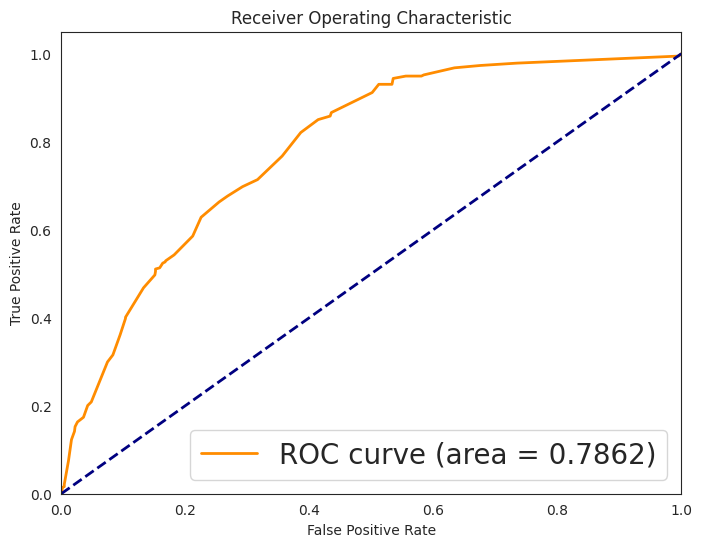


       Classification Report
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1033
           1       0.52      0.54      0.53       374

    accuracy                           0.74      1407
   macro avg       0.68      0.68      0.68      1407
weighted avg       0.75      0.74      0.75      1407




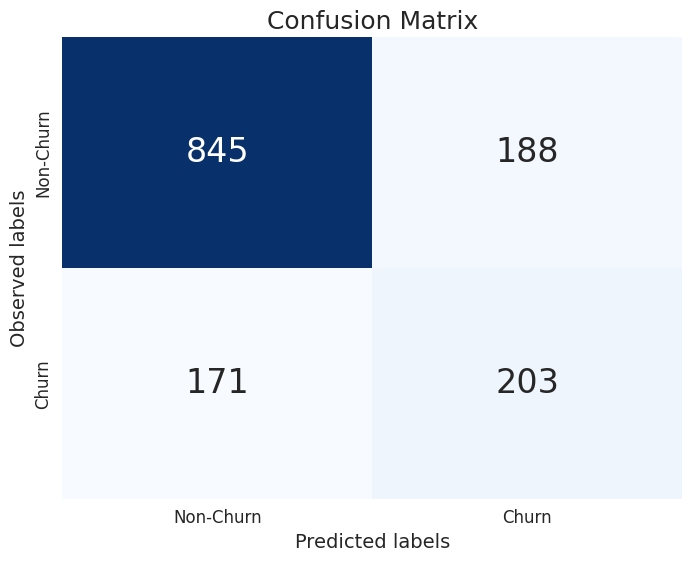

In [ ]:
# Create new datasets with optimal features and hyperparameters for the Decision Tree
X_train_dectree, X_test_dectree, best_dectree_params = columns_keep(best_dectree_params)

# Train the optimized Decision Tree model
tuned_model_dectree = DecisionTreeClassifier(random_state=42, **best_dectree_params)

# Evaluate the model and display the classification report and confusion matrix
get_classification_report_and_cm(
    X_train=X_train_dectree, X_test=X_test_dectree, model = tuned_model_dectree
)

In [ ]:
extract_importance(tuned_model_dectree, X_train_dectree)

Features sorted by importance:
Contract: 0.4686
Online_Security: 0.1010
Total_Charges: 0.0925
Avg_Monthly_GB_Download: 0.0809
Premium_Tech_Support: 0.0493
Online_Backup: 0.0353
Partner: 0.0311
Referred_a_Friend: 0.0269
Tech_Support: 0.0259
Payment_Method: 0.0227
Dependents: 0.0212
Gender: 0.0181
Streaming_TV: 0.0107
Streaming_Music: 0.0061
Device_Protection: 0.0059
Device_Protection_Plan: 0.0040
Phone_Service: 0.0000


We managed to get a small increase in the Score, but not that much wiht 500 trails.

## 4.3 Random Forest

In [ ]:
# Initialize the baseline Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Evaluate the baseline model
get_baseline(rf_model)

Baseline AUC: 0.8195


Already we can see that the random forest model is doing very good with just the deafault parameters.

For random forest we are just doing hyperparatmers tuning, and excluding feature selction. We have written about the why in the report

In [ ]:
# Hyperparameter optimization for Random Forest
def optimize_rf(trial):
  try:
    # Create a Random Forest model with hyperparameter tuning
    rf_model = RandomForestClassifier(
        n_estimators=trial.suggest_int('n_estimators', 50, 300),
        max_depth=trial.suggest_int('max_depth', 3, 30),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 5),
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        random_state=42,
        n_jobs=-1
    )

    # Cross-validation to evaluate model performance
    auc_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

    return auc_scores.mean()
  except Exception as e:
    print(f"Error during optimization: {e}")
    return 0.0  # Penalize failed trials

In [ ]:
# Run the optimization process and print the best hyperparameters
best_rf_params = optimize_study(optimize_rf, n_trials=10)
print(best_rf_params)

{'n_estimators': 88, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


AUC Score: 0.8245078194967155


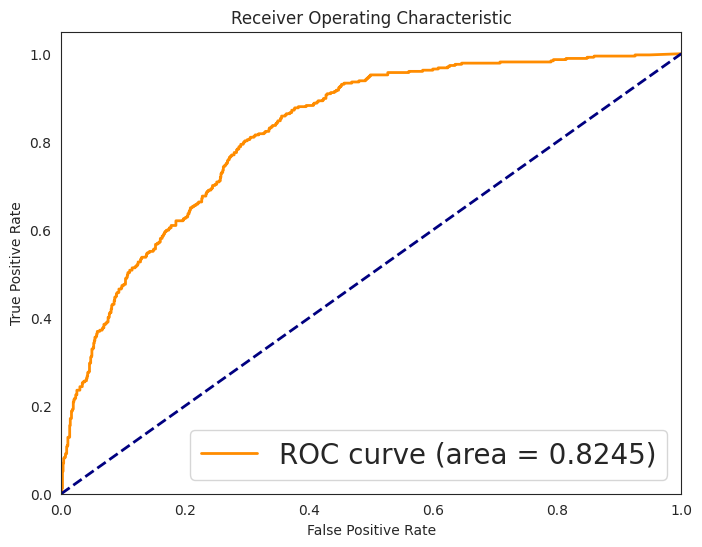


       Classification Report
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1033
           1       0.56      0.59      0.58       374

    accuracy                           0.77      1407
   macro avg       0.71      0.71      0.71      1407
weighted avg       0.77      0.77      0.77      1407




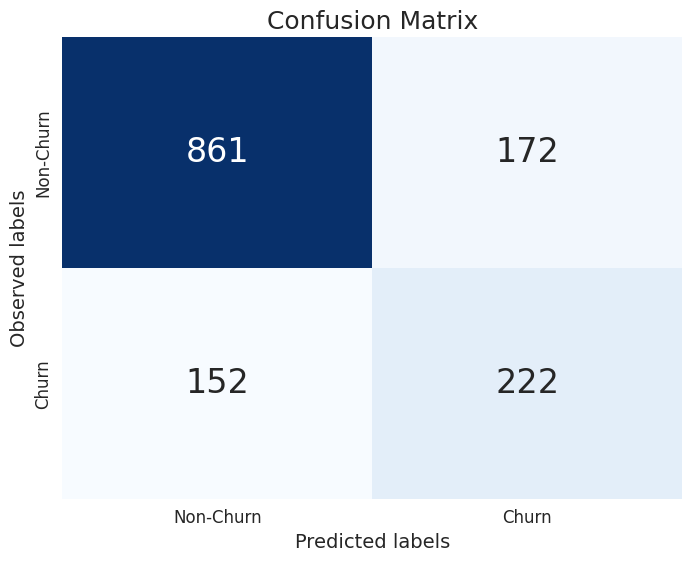

In [ ]:
# Train the optimized Random Forest model
rf_tuned = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)

# Evaluate the tuned model and display the classification report and confusion matrix
get_classification_report_and_cm(X_train, X_test, rf_tuned)

In [ ]:
extract_importance(rf_tuned.fit(X_train, y_train), X_train)

Features sorted by importance:
Contract: 0.1324
Online_Security: 0.0734
Monthly_Charges: 0.0677
Tenure: 0.0606
Total_Charges: 0.0573
Total_Revenue: 0.0568
Tech_Support: 0.0563
Paperless_Billing: 0.0559
Avg_Monthly_GB_Download: 0.0448
Total_Long_Distance_Charges: 0.0436
Avg_Monthly_Long_Distance_Charges: 0.0404
Age: 0.0378
Premium_Tech_Support: 0.0316
Online_Backup: 0.0290
Dependents: 0.0255
Internet_Service: 0.0240
Payment_Method: 0.0226
Partner: 0.0199
Referred_a_Friend: 0.0180
Device_Protection: 0.0134
Unlimited_Data: 0.0125
Gender: 0.0109
Total_Extra_Data_Charges: 0.0105
Device_Protection_Plan: 0.0092
Multiple_Lines: 0.0086
Streaming_TV: 0.0083
Streaming_Movies: 0.0079
Total_Refunds: 0.0072
Streaming_Music: 0.0059
Senior_Citizen: 0.0057
Phone_Service: 0.0024


In [ ]:
try:
  # Intentional exception to prevent accidental execution - remove to start optimization
  raise Exception('Optimization intentionally blocked - remove to run (takes ~1.5 hours)')
  # Run hyperparameter optimization for the Random Forest model
  best_rf_params = optimize_study(optimize_rf, n_trials=500)
  print(f'Optimal parameters for Random Forest: {best_rf_params}')
except Exception:
  print('Remove the intentional exception to start the optimization')

Remove the intentional exception to start the optimization


Given that we have previously run trails at 500 and noted the outcome, we can directly input the hyperparameters:

In [ ]:
# Predefined best hyperparameters from previous optimization (500 trials)
best_rf_params = {
  'n_estimators': 291,
  'max_depth': 19,
  'min_samples_split': 2,
  'min_samples_leaf': 1,
  'max_features': 'log2'
}

Run again but with best tuned parameters

AUC Score: 0.8197451998488385


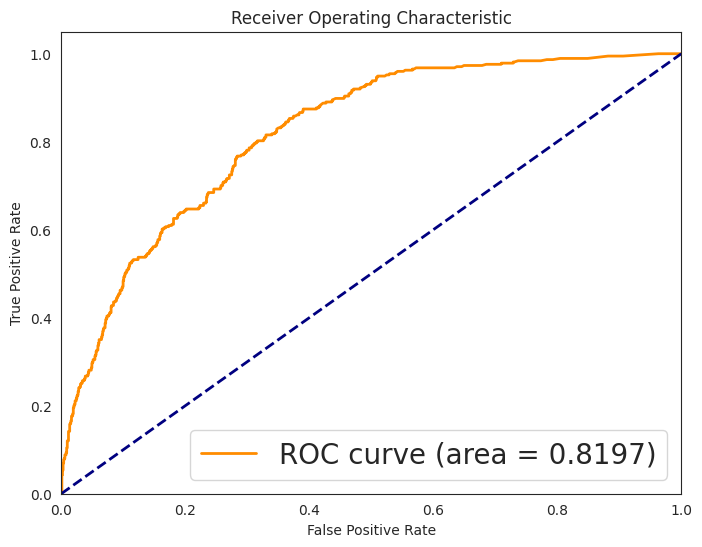


       Classification Report
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1033
           1       0.57      0.59      0.58       374

    accuracy                           0.77      1407
   macro avg       0.71      0.72      0.71      1407
weighted avg       0.78      0.77      0.78      1407




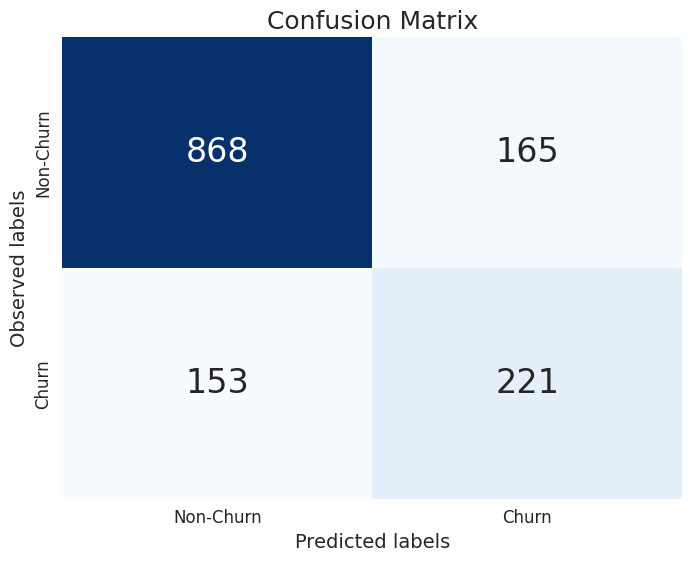

In [ ]:
# Train the optimized Random Forest model
rf_tuned = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)

# Evaluate the tuned model and display the classification report and confusion matrix
get_classification_report_and_cm(X_train, X_test, rf_tuned)

The model actually shows a slight less Auc score when running 500 trails compared to 10. We have written more about why, in the report

Find the best features influencing the model now now used

In [ ]:
extract_importance(rf_tuned.fit(X_train, y_train), X_train)

Features sorted by importance:
Contract: 0.0988
Monthly_Charges: 0.0720
Tenure: 0.0661
Total_Revenue: 0.0621
Total_Charges: 0.0620
Online_Security: 0.0586
Total_Long_Distance_Charges: 0.0524
Tech_Support: 0.0522
Avg_Monthly_GB_Download: 0.0486
Paperless_Billing: 0.0470
Avg_Monthly_Long_Distance_Charges: 0.0466
Age: 0.0452
Premium_Tech_Support: 0.0291
Payment_Method: 0.0263
Online_Backup: 0.0261
Dependents: 0.0253
Internet_Service: 0.0213
Referred_a_Friend: 0.0200
Partner: 0.0176
Device_Protection: 0.0161
Unlimited_Data: 0.0147
Gender: 0.0142
Total_Extra_Data_Charges: 0.0126
Multiple_Lines: 0.0120
Streaming_TV: 0.0101
Streaming_Movies: 0.0095
Device_Protection_Plan: 0.0085
Total_Refunds: 0.0083
Streaming_Music: 0.0080
Senior_Citizen: 0.0063
Phone_Service: 0.0028


## 4.4 Extreme Gradient Boosting

In [ ]:
# Initialize the baseline XGBoost model
xgb_default = XGBClassifier(random_state=42)

# Evaluate the baseline model
get_baseline(xgb_default)

Baseline AUC: 0.8176


The default XGBoost model already performs well, showcasing the strength and effectiveness of XGBoost as a predictive model.

Our next step is to see how much additional performance we can extract through fine-tuning. Since XGBoost shares similarities with decision trees, we will apply the same methodology, focusing on hyperparameter optimization and feature selection to maximize the model's predictive accuracy.

In [ ]:
def optimize_xgboost(trial):
  # Select features dynamically based on trial suggestions
  selected_features = []
  for feature in X_train.columns:
      if trial.suggest_categorical(f'include_{feature}', [True, False]):
          selected_features.append(feature)

  # Create a subset of the training data with the selected features
  X_train_selected = X_train[selected_features]

  # Define the hyperparameter search space for XGBoost
  params = {
      'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
      'max_depth': trial.suggest_int('max_depth', 3, 12),
      'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
      'subsample': trial.suggest_float('subsample', 0.5, 1.0),
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
      'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
      'reg_alpha': trial.suggest_float('reg_alpha', 0.00001, 1.0, log=True),
      'reg_lambda': trial.suggest_float('reg_lambda', 0.00001, 1.0, log=True),
    }

  # Initialize and train the XGBoost model with the selected features
  model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, **params)

  auc_scores = cross_val_score(model, X_train_selected, y_train, cv=10, scoring='roc_auc', n_jobs=-1)

  return auc_scores.mean()

In [ ]:
# Run hyperparameter optimization with 10 trials
xgboost_params = optimize_study(optimize_xgboost, n_trials=10)
# Print the best hyperparameters
print(f'Best parameters for XGboost: {xgboost_params}')

Best parameters for XGboost: {'include_Senior_Citizen': True, 'include_Partner': True, 'include_Dependents': True, 'include_Tenure': True, 'include_Phone_Service': True, 'include_Multiple_Lines': True, 'include_Internet_Service': False, 'include_Online_Security': True, 'include_Online_Backup': True, 'include_Device_Protection': True, 'include_Tech_Support': True, 'include_Streaming_TV': False, 'include_Streaming_Movies': True, 'include_Contract': False, 'include_Paperless_Billing': False, 'include_Payment_Method': False, 'include_Monthly_Charges': False, 'include_Total_Charges': False, 'include_Gender': False, 'include_Age': True, 'include_Referred_a_Friend': False, 'include_Avg_Monthly_Long_Distance_Charges': True, 'include_Avg_Monthly_GB_Download': True, 'include_Device_Protection_Plan': False, 'include_Premium_Tech_Support': False, 'include_Streaming_Music': False, 'include_Unlimited_Data': True, 'include_Total_Refunds': False, 'include_Total_Extra_Data_Charges': False, 'include_Tot

AUC Score: 0.8213422304590234


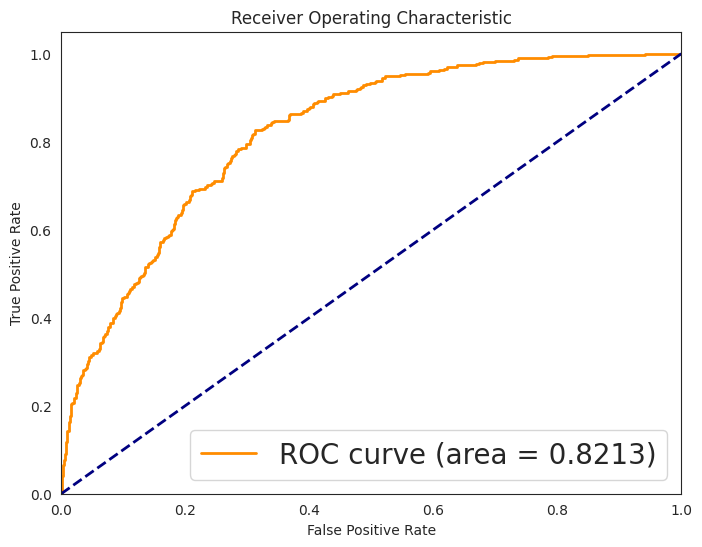


       Classification Report
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1033
           1       0.55      0.59      0.57       374

    accuracy                           0.76      1407
   macro avg       0.70      0.71      0.70      1407
weighted avg       0.77      0.76      0.76      1407




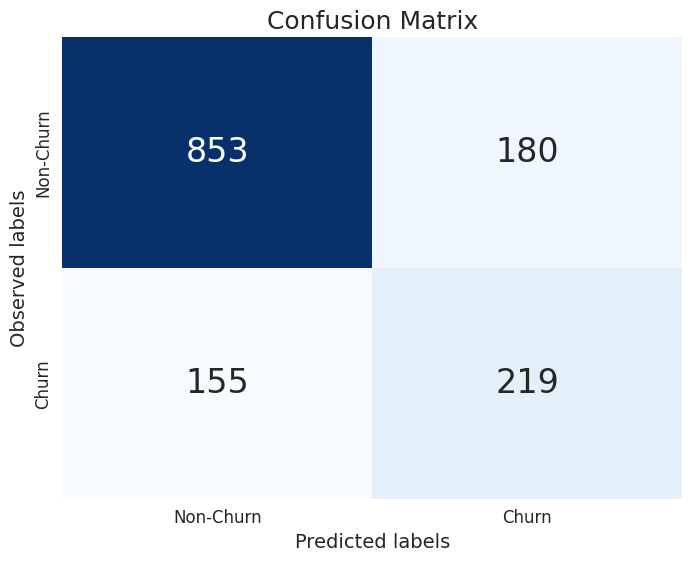

In [ ]:
# Filter only hyperparameters from xgboost_params
model_params = {key: value for key, value in xgboost_params.items() if not key.startswith('include_')}

# Create the XGBoost model using the best parameters
xgb_tuned = XGBClassifier(
    **model_params,
    eval_metric='logloss',  # Keep the evaluation metric
    random_state=42
)

# Run evaluation: AUC, ROC, Confusion Matrix
get_classification_report_and_cm(X_train, X_test, xgb_tuned)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:12:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "include_Age", "include_Avg_Monthly_GB_Download", "include_Avg_Monthly_Long_Distance_Charges", "include_Contract", "include_Dependents", "include_Device_Protection", "include_Device_Protection_Plan", "include_Gender", "include_Internet_Service", "include_Monthly_Charges", "include_Multiple_Lines", "include_Online_Backup", "include_Online_Security", "include_Paperless_Billing", "include_Partner", "include_Payment_Method", "include_Phone_Service", "include_Premium_Tech_Support", "include_Referred_a_Friend", "include_Senior_Citizen", "include_Streaming_Movies", "include_Streaming_Music", "include_Streaming_TV", "include_Tech_Support", "include_Tenure", "include_Total_Charges", "include_Total_Extra_Data_Charges", "include_Total_Long_Distance_Charges", "include_Total_Refunds", "include_Total_Revenue", "include_Unlimited_Data", "use_label_encoder" } are 

AUC Score: 0.8213422304590234


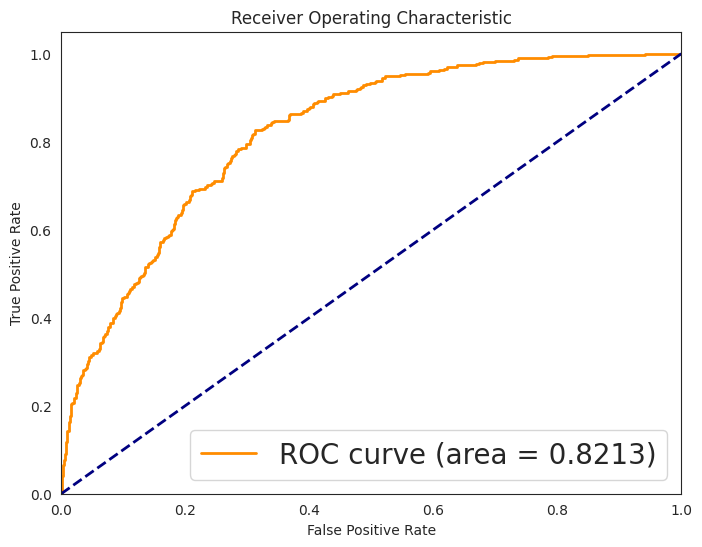


       Classification Report
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1033
           1       0.55      0.59      0.57       374

    accuracy                           0.76      1407
   macro avg       0.70      0.71      0.70      1407
weighted avg       0.77      0.76      0.76      1407




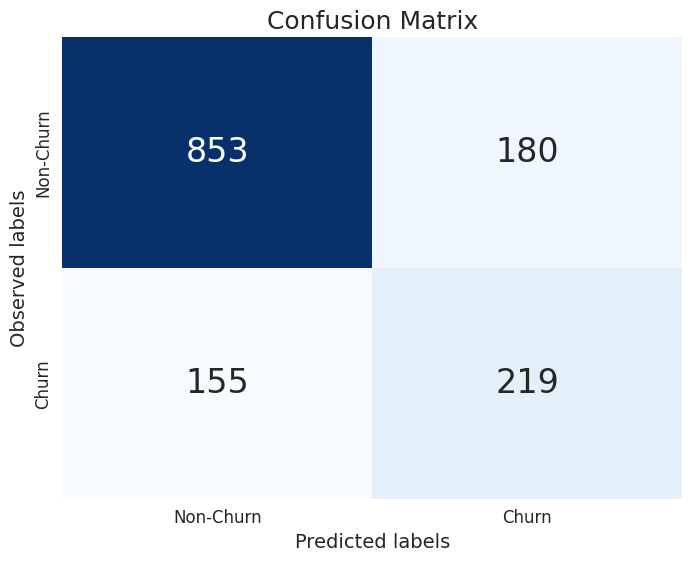

In [ ]:
# Create model with best parameters
xgb_tuned = XGBClassifier(
  **xgboost_params,
  use_label_encoder=False,
  eval_metric='logloss',
  random_state=42
)

# Run evaluation: AUC, ROC, Confusion Matrix
get_classification_report_and_cm(X_train, X_test, xgb_tuned)

In [ ]:
extract_importance(xgb_tuned.fit(X_train, y_train), X_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:12:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "include_Age", "include_Avg_Monthly_GB_Download", "include_Avg_Monthly_Long_Distance_Charges", "include_Contract", "include_Dependents", "include_Device_Protection", "include_Device_Protection_Plan", "include_Gender", "include_Internet_Service", "include_Monthly_Charges", "include_Multiple_Lines", "include_Online_Backup", "include_Online_Security", "include_Paperless_Billing", "include_Partner", "include_Payment_Method", "include_Phone_Service", "include_Premium_Tech_Support", "include_Referred_a_Friend", "include_Senior_Citizen", "include_Streaming_Movies", "include_Streaming_Music", "include_Streaming_TV", "include_Tech_Support", "include_Tenure", "include_Total_Charges", "include_Total_Extra_Data_Charges", "include_Total_Long_Distance_Charges", "include_Total_Refunds", "include_Total_Revenue", "include_Unlimited_Data", "use_label_encoder" } are 

Features sorted by importance:
Contract: 0.2778
Paperless_Billing: 0.0897
Tech_Support: 0.0638
Premium_Tech_Support: 0.0624
Online_Security: 0.0624
Dependents: 0.0478
Referred_a_Friend: 0.0415
Internet_Service: 0.0336
Partner: 0.0307
Unlimited_Data: 0.0211
Online_Backup: 0.0202
Total_Extra_Data_Charges: 0.0174
Monthly_Charges: 0.0164
Tenure: 0.0163
Senior_Citizen: 0.0159
Payment_Method: 0.0158
Gender: 0.0157
Device_Protection: 0.0139
Total_Refunds: 0.0137
Device_Protection_Plan: 0.0137
Total_Charges: 0.0121
Streaming_Music: 0.0113
Avg_Monthly_GB_Download: 0.0109
Streaming_Movies: 0.0107
Phone_Service: 0.0101
Multiple_Lines: 0.0100
Total_Revenue: 0.0096
Total_Long_Distance_Charges: 0.0096
Streaming_TV: 0.0090
Age: 0.0085
Avg_Monthly_Long_Distance_Charges: 0.0082


Due to the broad hyperparameter space, finding improvements over the default model needed substantial computation. For demonstration, we've set trials to 10, but running 500 trials, which we've done, yields better results. This can be achieved by fixing the Exception below, but be prepared for a longer computation time.

In [ ]:
try:
  raise Exception('THIS ERROR IS HERE ON PURPOSE') # Remove this to run (takes some time - approx 1,5 hours. depending on PC)
  xgboost_params = optimize_study(optimize_xgboost, n_trials=500)
  print(f'Best params for XGboost: {xgboost_params}')
except Exception:
  print('Remove Exception to run')

Remove Exception to run


Given that we have previously had n_trails at 500 and noted the outcome, we can directly input the hyperparameters:

In [ ]:
xgboost_params = {'include_Senior_Citizen': False, 'include_Partner': True, 'include_Dependents': True,
                  'include_Tenure': False, 'include_Phone_Service': False, 'include_Multiple_Lines': False,
                  'include_Internet_Service': True, 'include_Online_Security': True, 'include_Online_Backup': True,
                  'include_Device_Protection': False, 'include_Tech_Support': True, 'include_Streaming_TV': True,
                  'include_Streaming_Movies': True, 'include_Contract': True, 'include_Paperless_Billing': True,
                  'include_Payment_Method': True, 'include_Monthly_Charges': True, 'include_Total_Charges': False,
                  'include_Gender': True, 'include_Age': True, 'include_Referred_a_Friend': True,
                  'include_Avg_Monthly_Long_Distance_Charges': True, 'include_Avg_Monthly_GB_Download': False,
                  'include_Device_Protection_Plan': True, 'include_Premium_Tech_Support': False, 'include_Streaming_Music': True,
                  'include_Unlimited_Data': True, 'include_Total_Refunds': True, 'include_Total_Extra_Data_Charges': True,
                  'include_Total_Long_Distance_Charges': True, 'include_Total_Revenue': True, 'n_estimators': 910,
                  'max_depth': 11, 'learning_rate': 0.011153124044963202, 'subsample': 0.7917610078664522,
                  'colsample_bytree': 0.6567963910539792, 'min_child_weight': 1, 'reg_alpha': 0.000146260872734251,
                  'reg_lambda': 0.6973202379748128}


AUC Score: 0.8247614807605697


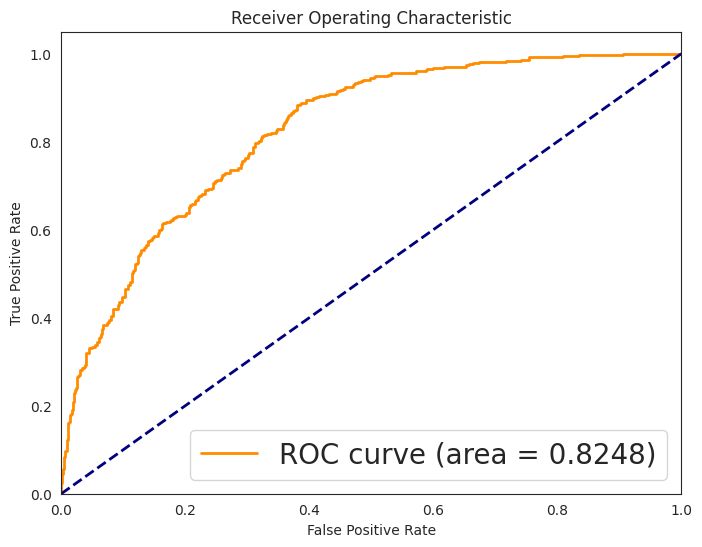


       Classification Report
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1033
           1       0.60      0.56      0.58       374

    accuracy                           0.78      1407
   macro avg       0.72      0.71      0.72      1407
weighted avg       0.78      0.78      0.78      1407




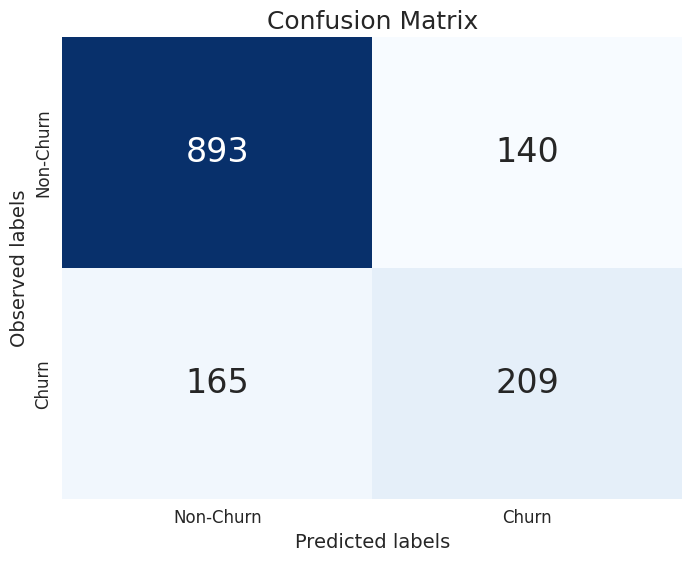

In [ ]:
# Filter only hyperparameters from xgboost_params
model_params = {key: value for key, value in xgboost_params.items() if not key.startswith('include_')}

# Create the XGBoost model using the best parameters
xgb_tuned = XGBClassifier(
    **model_params,
    eval_metric='logloss',  # Keep the evaluation metric
    random_state=42
)

# Run evaluation: AUC, ROC, Confusion Matrix
get_classification_report_and_cm(X_train, X_test, xgb_tuned)


Since we did feature selection, the new the set of features used to train the model may differ from the features available in the current input dataset.

This discrepancy can cause the model's feature importance array to have a different length than the feature names extracted from the dataset. To address this, we include an extra block of code to dynamically check and handle any length mismatch between the model's expected features and the actual input data.

In [ ]:
def extract_importance(model, X_train):
  importances = model.feature_importances_
  feature_names = X_train.columns

  # Check for any length mismatch and print a warning if needed
  if len(importances) != len(feature_names):
      print(f"Warning: Model has {len(importances)} features, but input data has {len(feature_names)} features.")

  # Pair feature names with their importance and sort by importance
  feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

  print("Features sorted by importance:")
  for name, importance in feature_importance:
      print(f"{name}: {importance:.4f}")

In [ ]:
extract_importance(xgb_tuned, X_train)

Features sorted by importance:
Contract: 0.3351
Online_Security: 0.0735
Paperless_Billing: 0.0724
Tech_Support: 0.0609
Premium_Tech_Support: 0.0583
Dependents: 0.0365
Internet_Service: 0.0344
Unlimited_Data: 0.0284
Referred_a_Friend: 0.0265
Partner: 0.0243
Online_Backup: 0.0228
Total_Extra_Data_Charges: 0.0138
Tenure: 0.0129
Senior_Citizen: 0.0129
Device_Protection: 0.0127
Monthly_Charges: 0.0126
Device_Protection_Plan: 0.0124
Streaming_Movies: 0.0122
Phone_Service: 0.0121
Payment_Method: 0.0121
Total_Charges: 0.0117
Gender: 0.0113
Streaming_TV: 0.0112
Streaming_Music: 0.0110
Multiple_Lines: 0.0107
Total_Refunds: 0.0104
Total_Revenue: 0.0103
Total_Long_Distance_Charges: 0.0098
Avg_Monthly_GB_Download: 0.0096
Avg_Monthly_Long_Distance_Charges: 0.0090
Age: 0.0084


## 4.5 Setting new Treshold for added Business Value

In [ ]:
# Estimates the optimal classification threshold based on Youden's J statistic and Balanced Point.
def estimate_optimal_threshold(model, X_test, y_test):
  # Convert test data to DMatrix (XGBoost specific)
  dtest = xgb.DMatrix(X_test)

  # Predict probabilities directly without DMatrix
  y_pred_proba = model.predict_proba(X_test)[:, 1]

  # Generate ROC curve values
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

  # Youden’s J statistic method: TPR - FPR
  optimal_idx_j = (tpr - fpr).argmax()
  optimal_threshold_j = thresholds[optimal_idx_j]

  # Balanced point method: minimizing the difference between TPR and (1 - FPR)
  optimal_idx_balanced = (abs(tpr - (1 - fpr))).argmin()
  optimal_threshold_balanced = thresholds[optimal_idx_balanced]

  print(f"Optimal Threshold using Youden's J: {optimal_threshold_j:.2f}")
  print(f"Optimal Threshold using Balanced Point: {optimal_threshold_balanced:.2f}")

  return optimal_threshold_j, optimal_threshold_balanced

In [ ]:
# Call the function with the tuned XGBoost model
optimal_threshold_j, optimal_threshold_balanced = estimate_optimal_threshold(xgb_tuned, X_test, y_test)
print(f"Optimal Threshold using Youden's J: {optimal_threshold_j}")
print(f"Optimal Threshold using Balanced Point: {optimal_threshold_balanced}")

Optimal Threshold using Youden's J: 0.12
Optimal Threshold using Balanced Point: 0.25
Optimal Threshold using Youden's J: 0.1179819107055664
Optimal Threshold using Balanced Point: 0.2539801001548767



Classification Report (Threshold = 0.28)
              precision    recall  f1-score   support

           0       0.88      0.74      0.81      1033
           1       0.50      0.71      0.59       374

    accuracy                           0.74      1407
   macro avg       0.69      0.73      0.70      1407
weighted avg       0.78      0.74      0.75      1407




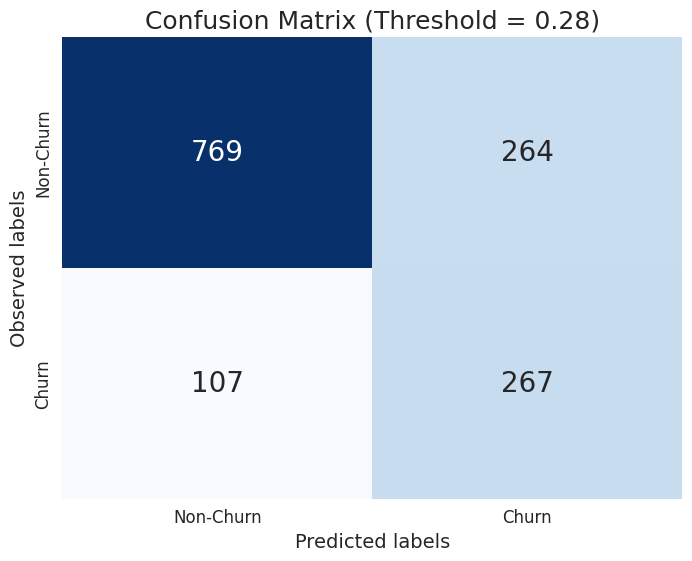

In [ ]:
# manually put a new threshold for XGboost Model
threshold_input = 0.28

y_pred_proba_rf = xgb_tuned.predict_proba(X_test)[:, 1]

evaluate_with_custom_threshold(y_test, y_pred_proba_rf, threshold=threshold_input)